In [1]:
%matplotlib inline
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy.stats import beta, expon, truncnorm, norm, uniform
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from utils import *
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re
pd.options.display.float_format = '{:,g}'.format
plt.style.use(['ggplot'])

In [2]:
filename = "./data/pululagua/pulu_real_data.csv"

raw_df, grid = io.import_pululagua(filename)

grid.to_csv("data/pululagua/pulu_grid.csv", sep=" ", header=False, index=False)

display(raw_df)

,Sample,Easting,Northing,Altitude,Thickness,MassArea,"[-8,-7)","[-7,-6)","[-6,-5)","[-5,-4)",...,"[6,7)","[7,8)","[8,9)","[9,10)","[10,11)",total,Md(phi),Sorting,SkG,radius
5,PL12,4105,1558,2358,16.5,165,0,0,8.883,12.031,...,0.1992,0.0791,0.0167,0.0032,0.0003,100,-1.67,2.68,-0.02,"4,390.72"
24,PL40,1032,-4703,2599,28,280,8.3376,14.9262,17.4488,11.5976,...,0.1037,0.0352,0.0085,0.0018,0.0001,100,-4.2,2.96,0.23,"4,814.9"
25,PL41,1018,-4731,2615,35,350,14.8198,5.6495,21.5207,11.558,...,0.1218,0.0388,0.0078,0.0015,0.0001,100,-4.31,2.73,0.09,"4,839.29"
4,PL11,5068,-1933,2738,17,170,0,0,5.2455,11.5143,...,0.0918,0.0386,0.0083,0.0016,0.0002,99.9999,-1.63,2.45,0.01,"5,424.12"
6,PL13,5463,3958,1934,14,140,0,0,2.8661,8.5053,...,0.3046,0.1448,0.0334,0.0066,0.0004,100,-0.5,2.42,-0.2,"6,746.12"
26,PL43,3116,-6859,2456,18,180,0,11.3857,11.0999,11.1971,...,0.0896,0.0328,0.0073,0.0011,0.0001,100,-2.71,2.95,0.03,"7,533.61"
3,PL10,5562,-5274,2361,17.5,175,0,0,3.4276,14.4473,...,0.0657,0.0238,0.0056,0.0012,0.0001,100,-1.96,2.4,0.09,"7,664.91"
2,PL07,-5132,-5822,2760,23.5,235,0,7.0853,10.7979,10.5995,...,0.1328,0.0509,0.0127,0.0025,0.0001,100,-2.37,2.87,0.02,"7,761"
38,PL57,-6347,-4763,2625,30,300,0,0,2.9079,7.9271,...,0.0831,0.0286,0.0063,0.0012,0.0001,100,-1.33,2.26,-0.01,"7,935.4"
32,PL51,-7324,-4067,2695,26,260,0,0,3.7711,6.212,...,0.1446,0.0536,0.0128,0.0028,0.0002,100,-1.7,2.23,0.12,"8,377.44"


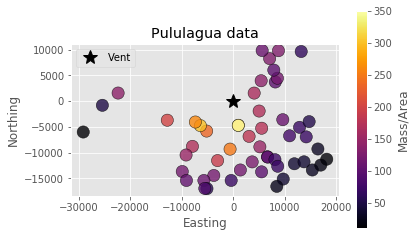

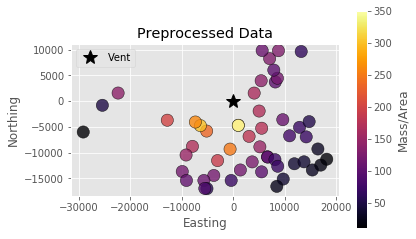

In [3]:
vis.plot_sample(raw_df, vent=(0,0), log=False, title="Pululagua data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("pululagua/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()

#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("pululagua/All_trans.png", dpi=200, format='png')
plt.show()

In [4]:
t2_df, _, _, _ = io.read_tephra2("data/pululagua/pulu_out.txt")

t2_df["Residual"] = t2_df["MassArea"].values/obs_df["MassArea"].values

display(t2_df.head())

,Easting,Northing,Elevation,MassArea,"[-8,-7)","[-7,-6)","[-6,-5)","[-5,-4)","[-4,-3)","[-3,-2)",...,"[3,4)","[4,5)","[5,6)","[6,7)","[7,8)","[8,9)","[9,10)","[10,11)",radius,Residual
0,4105,1558,0,159.345,0.0696127,0.363263,1.41018,4.11607,9.1122,15.4036,...,1.57705,0.0499285,0.000736347,7.41802e-06,5.50103e-08,2.55349e-10,9.14655e-13,2.54016e-15,"4,390.72",0.965727
1,1032,-4703,0,180.987,0.0579496,0.311125,1.23449,3.66294,8.20795,13.998,...,2.03938,0.0468926,0.000654533,6.53995e-06,4.84418e-08,2.24821e-10,8.05287e-13,2.23642e-15,"4,814.9",0.646382
2,1018,-4731,0,180.914,0.057607,0.309804,1.23085,3.65573,8.19777,13.9882,...,2.04084,0.0469223,0.000654824,6.54263e-06,4.84614e-08,2.24912e-10,8.05612e-13,2.23733e-15,"4,839.29",0.516897
3,5068,-1933,0,152.806,0.0548726,0.307602,1.26261,3.84461,8.7833,15.1939,...,1.58051,0.0521082,0.000768194,7.73605e-06,5.73652e-08,2.66277e-10,9.53798e-13,2.64887e-15,"5,424.12",0.898859
4,5463,3958,0,134.37,0.0400833,0.248334,1.10428,3.57868,8.57208,15.3609,...,1.36057,0.0571784,0.000869457,8.79166e-06,6.52298e-08,3.02807e-10,1.08466e-12,3.0123e-15,"6,746.12",0.959786


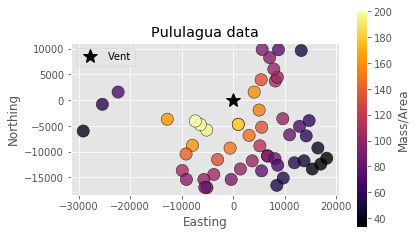

In [5]:
vis.plot_sample(t2_df, vent=(0,0), log=False, title="Pululagua data", cbar_label="Mass/Area")
plt.show()

In [6]:
config = io.read_tephra2_config("data/pululagua/pulu_config.txt")

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}

# Update parameters
config["COL_STEPS"] = 20
config["PART_STEPS"] = 19

config["MAX_GRAINSIZE"] = -8
config["MIN_GRAINSIZE"] = 11

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 0.1

print("INPUT PARAMETERS:")
display(config)
display(globs)

INPUT PARAMETERS:


{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 2500.0,
 'PLUME_HEIGHT': 27000.0,
 'ALPHA': 1.1,
 'BETA': 1.1,
 'ERUPTION_MASS': 250000000000.0,
 'MAX_GRAINSIZE': -8,
 'MIN_GRAINSIZE': 11,
 'MEDIAN_GRAINSIZE': -0.2,
 'STD_GRAINSIZE': 2.0,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 92066.0,
 'FALL_TIME_THRESHOLD': 3600.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 19,
 'PLUME_MODEL': 2.0,
 'WIND_SPEED': 0.1}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

,centroid,density,interval,lower,probability,upper
0,-7.5,"1,024","[-8,-7)",-8,9.93277e-05,-7
1,-6.5,"1,024","[-7,-6)",-7,0.00061611,-6
2,-5.5,"1,024","[-6,-5)",-6,0.00297627,-5
3,-4.5,"1,024","[-5,-4)",-5,0.0111973,-4
4,-3.5,"1,024","[-4,-3)",-4,0.0328079,-3
5,-2.5,"1,024","[-3,-2)",-3,0.0748637,-2
6,-1.5,"1,024","[-2,-1)",-2,0.133043,-1
7,-0.5,"1,024","[-1,0)",-1,0.184135,0
8,0.5,"1,233.5","[0,1)",0,0.198476,1
9,1.5,"1,443","[1,2)",1,0.166612,2


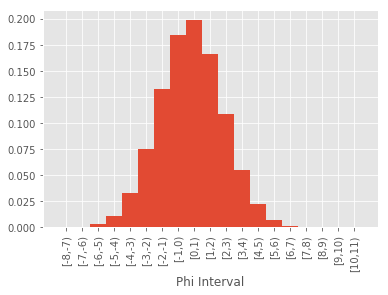

In [7]:
phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display(pd.DataFrame(phi_steps))



probs = [phi["probability"] for phi in phi_steps]
x = [phi["centroid"] for phi in phi_steps]
labels = [phi["interval"] for phi in phi_steps]
fig, ax = plt.subplots(facecolor='w', edgecolor='k')
ax.bar(x, probs, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
plt.xlabel("Phi Interval")
plt.show()

In [8]:
t = process_time()
t_tot = process_time()
df_list = []

q_dist = beta(config["ALPHA"],config["BETA"])

grid = obs_df[["Easting", "Northing"]]
wind_angle = np.radians(200)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
for phi_step in phi_steps:
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    input_table, gsm_df, sig, vv, tft= gaussian_stack_single_phi(
        grid, 20, config["VENT_ELEVATION"], 
        config["PLUME_HEIGHT"], 
        (config["ALPHA"], config["BETA"]),
        mass_in_phi, (u,v), 
        phi_step["lower"], phi_step["density"], 0,
        config["DIFFUSION_COEFFICIENT"],
        config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"])
    df_list.append(gsm_df.rename(columns={"MassArea":phi_step["interval"]}))


elapsed_time = process_time() - t
print("Forward Sim time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge = reduce(lambda x, y: pd.merge(x, y, on =['Northing', 'Easting']), df_list)
elapsed_time = process_time() - t
print("Dataframe Merge time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge["MassArea"] = np.sum(df_merge[labels], 1)
elapsed_time = process_time() - t
print("Tot M/A calc time: %.5f seconds"%elapsed_time)

t = process_time()
for label in labels:
    df_merge[label] = df_merge.apply(lambda row: (row[label]/row["MassArea"])*100, axis=1) # This operation is much faster

elapsed_time = process_time() - t
print("Phi Wt perc calc time: %.5f seconds"%elapsed_time)

total_time = process_time() - t_tot
print("Total time: %.5f seconds"%total_time)

forward_df = df_merge

# forward_df["MassArea"] = forward_df["MassArea"]*(6991/9469)

forward_df["radius"] = np.sqrt(forward_df["Easting"]**2 + forward_df["Northing"]**2)
forward_df = forward_df.sort_values(by=['radius'])
forward_df["Residual"] = forward_df["MassArea"].values/obs_df["MassArea"].values
display(forward_df.head())

Forward Sim time: 0.07812 seconds
Dataframe Merge time: 0.07812 seconds
Tot M/A calc time: 0.00000 seconds
Phi Wt perc calc time: 0.01562 seconds
Total time: 0.17188 seconds


,Northing,Easting,"[-8,-7)","[-7,-6)","[-6,-5)","[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)",...,"[4,5)","[5,6)","[6,7)","[7,8)","[8,9)","[9,10)","[10,11)",MassArea,radius,Residual
0,1558,4105,0.0534419,0.279426,1.08655,3.17671,7.04596,11.9391,15.5367,15.3548,...,0.0497974,0.000630067,5.9401e-06,4.26281e-08,1.94426e-10,6.90354e-13,1.90886e-15,219.327,"4,390.72",1.32926
1,-4703,1032,0.0484693,0.260849,1.03713,3.08341,6.92412,11.8389,15.5072,15.3979,...,0.0504801,0.000638191,6.01531e-06,4.31662e-08,1.96879e-10,6.99064e-13,1.93294e-15,216.594,"4,814.9",0.773551
2,-4731,1018,0.0482061,0.259874,1.03462,3.079,6.91932,11.8371,15.5109,15.4059,...,0.0505384,0.000638962,6.02258e-06,4.32183e-08,1.97117e-10,6.99909e-13,1.93528e-15,216.333,"4,839.29",0.618094
3,-1933,5068,0.0423631,0.23815,0.979702,2.98916,6.84345,11.8682,15.7065,15.7127,...,0.0523607,0.000664193,6.26241e-06,4.49411e-08,2.04976e-10,7.27813e-13,2.01243e-15,208.039,"5,424.12",1.22376
4,3958,5463,0.0302957,0.188481,0.840588,2.73055,6.55544,11.7775,15.9957,16.3078,...,0.0567007,0.000722904,6.81802e-06,4.89296e-08,2.23168e-10,7.92409e-13,2.19104e-15,191.08,"6,746.12",1.36486


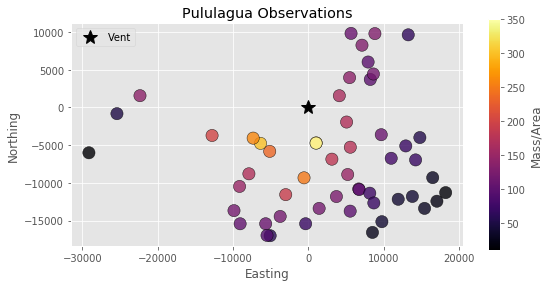

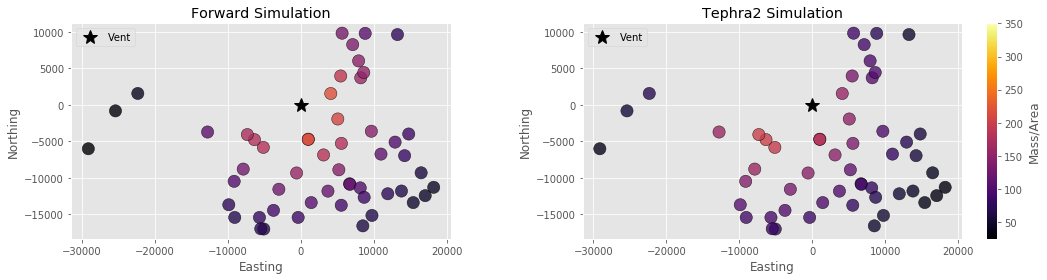

In [9]:
# fig, axs = plt.subplots(3,1, figsize=(
#         8,9), facecolor='w', edgecolor='k')
# axs = axs.ravel()

# vis.plot_sample(obs_df, vent=(0,0), log=False, 
#             title="Colima Observations", cbar_label="Mass/Area", ax=axs[0])
# vis.plot_sample(forward_df, vent=(0,0), log=False, 
#             title="Forward Simulation", cbar_label="Mass/Area", ax=axs[1])
# # vis.plot_sample(t2_const_df, vent=(0,0), log=False, 
# #             title="Tephra2 Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[2])
# vis.plot_sample(t2_df, vent=(0,0), log=False, 
#             title="Tephra2 Simulation", cbar_label="Mass/Area", ax=axs[2])

# plt.tight_layout()
# plt.show()

# fig, axs = plt.subplots(1,2, figsize=(
#         12,3), facecolor='w', edgecolor='k')
# axs = axs.ravel()


# vis.plot_sample(forward_df, vent=(0,0), log=True, values="Residual",
#             title="Forward Simulation", 
#             cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[0])
# # vis.plot_sample(t2_const_df, vent=(0,0), log=True, values="Residual",
# #             title="Tephra2 Simulation (Const. Wind)", 
# #             cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[1])
# vis.plot_sample(t2_df, vent=(0,0), log=True, values="Residual",
#             title="Tephra2 Simulation", 
#             cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[1])




# plt.tight_layout()
# plt.show()


bounds = (25, 350)

fig, ax = plt.subplots(1, 1, figsize=(8,4))

vis.plot_sample(obs_df, vent=(0,0), log=False, bounds=None,
            title="Pululagua Observations", cbar_label="Mass/Area", ax = ax)
plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(
        15.5,4), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(forward_df, vent=(0,0), log=False, bounds=bounds, show_cbar=False,
            title="Forward Simulation", cbar_label="Mass/Area", ax=axs[0])
vis.plot_sample(t2_df, vent=(0,0), log=False, bounds=bounds, show_cbar=True,
            title="Tephra2 Simulation", cbar_label="Mass/Area", ax=axs[1])

plt.tight_layout()
plt.show()




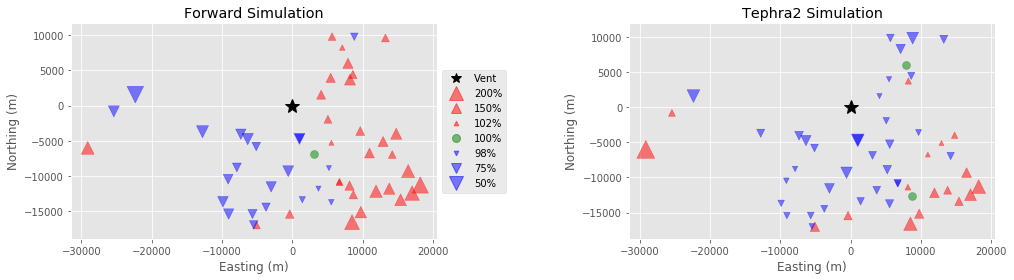

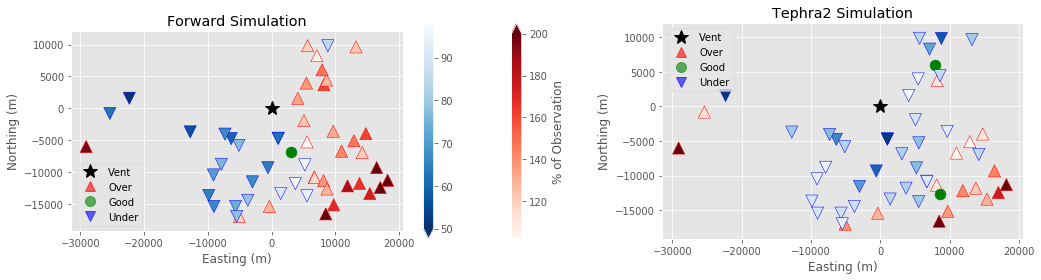

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(
        15.5,4), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_residuals(forward_df, vent=(0,0), values="Residual",
            title="Forward Simulation", show_legend=True,
            plot_type = "size", ax=axs[0])
vis.plot_residuals(t2_df, vent=(0,0), values="Residual",
            title="Tephra2 Simulation", show_legend=False,
             plot_type = "size", ax=axs[1])


plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(
        15.5,4), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_residuals(forward_df, vent=(0,0), values="Residual",
            title="Forward Simulation", 
            plot_type = "cmap", ax=axs[0], show_cbar = True)
vis.plot_residuals(t2_df, vent=(0,0), values="Residual",
            title="Tephra2 Simulation", 
             plot_type = "cmap", ax=axs[1], show_cbar = False)


plt.tight_layout()
plt.show()

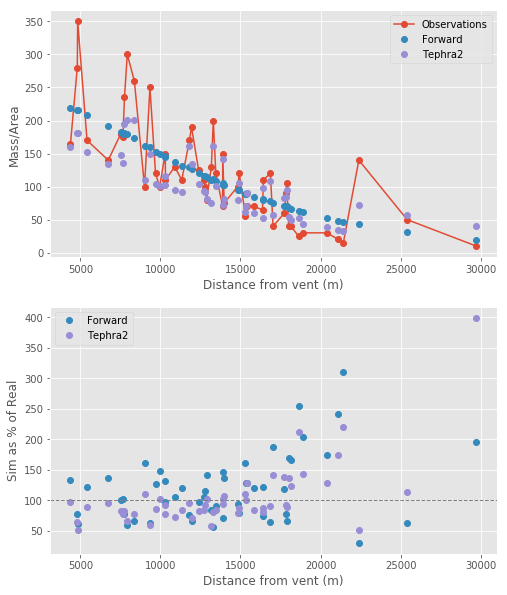

In [11]:
fig, axs = plt.subplots(2,1, figsize=(
        8,10), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C0o-', label="Observations")
# plt.plot(rotdf["radius"].values, rotdf["MassArea"].values, 'C1o-')
axs[0].plot(forward_df["radius"].values, forward_df["MassArea"].values, 'C1o', label="Forward")
axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C2o', label="Tephra2")
axs[0].legend()
axs[0].set_xlabel("Distance from vent (m)")
axs[0].set_ylabel("Mass/Area")

axs[1].plot(forward_df["radius"].values, forward_df["Residual"].values*100, 'C1o', label="Forward")
axs[1].plot(t2_df["radius"].values, t2_df["Residual"].values*100, 'C2o', label="Tephra2")
axs[1].axhline(100, linestyle="--", lw=1, c="gray")
axs[1].legend()
axs[1].set_xlabel("Distance from vent (m)")
axs[1].set_ylabel("Sim as % of Real")
plt.show()

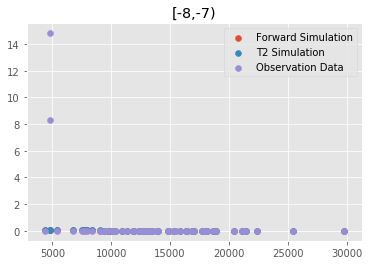

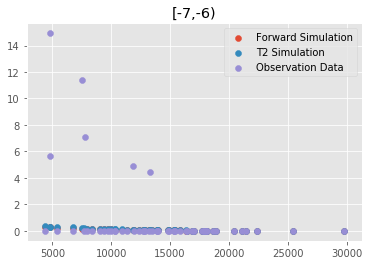

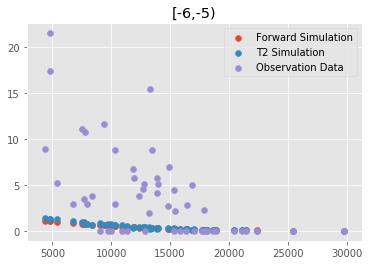

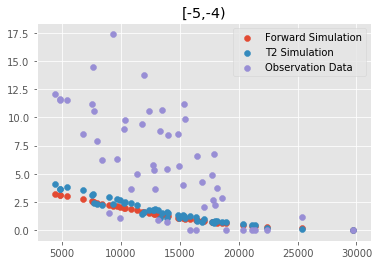

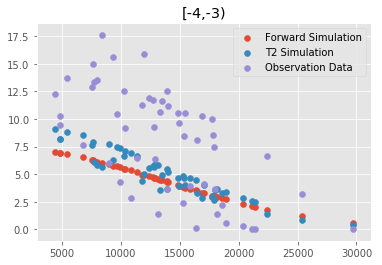

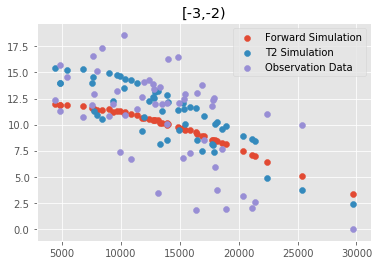

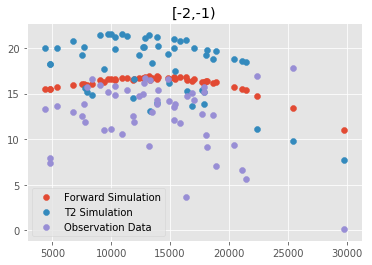

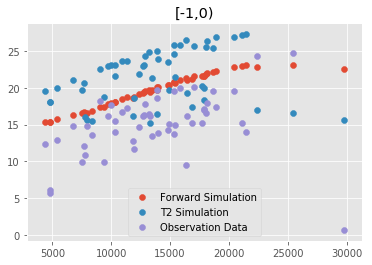

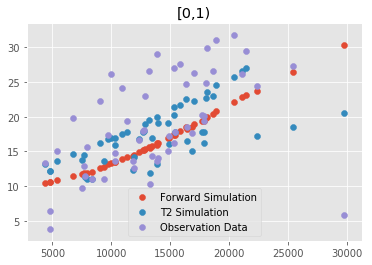

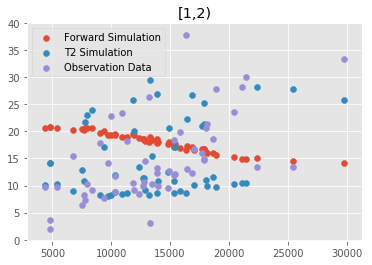

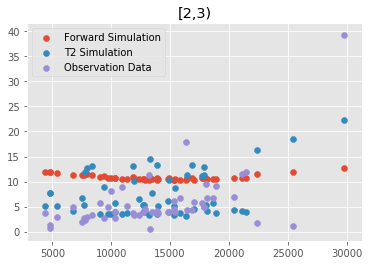

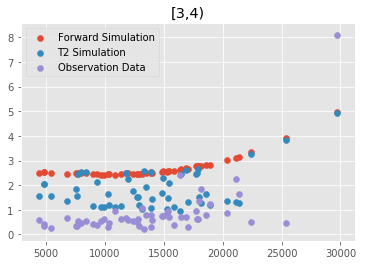

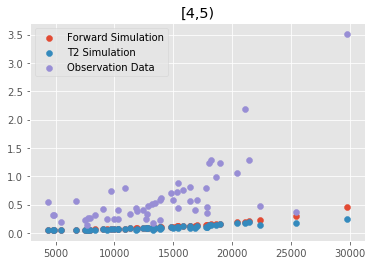

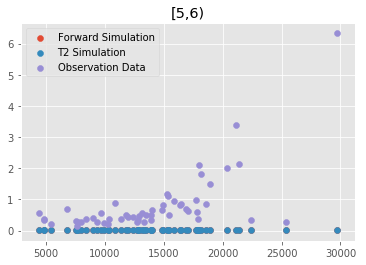

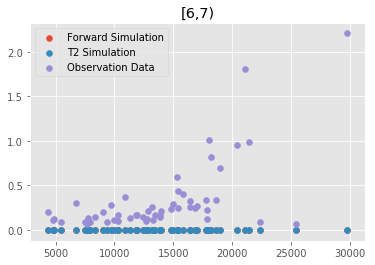

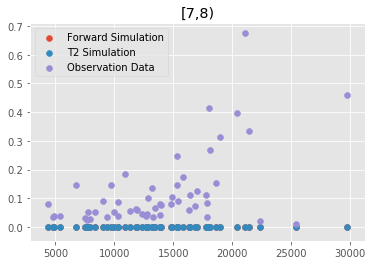

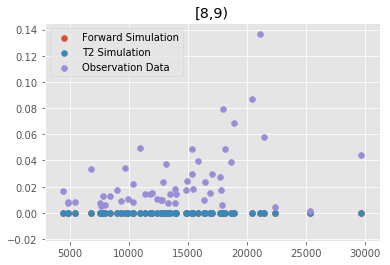

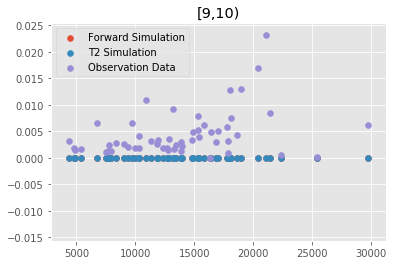

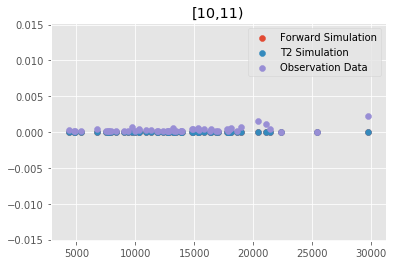

In [12]:
#TGSD calculation?
forward_tgsd = []
t2_tgsd = []
obs_tgsd = []
for phi_step in phi_steps:
    plt.scatter(forward_df["radius"], forward_df[phi_step["interval"]], label="Forward Simulation")
    plt.scatter(t2_df["radius"], t2_df[phi_step["interval"]], label="T2 Simulation")
    plt.scatter(obs_df["radius"], obs_df[phi_step["interval"]], label="Observation Data")
    plt.legend()
    plt.title(phi_step["interval"])
    plt.show()
    
    forward_tgsd += [forward_df[phi_step["interval"]].sum()/len(forward_df)]
    t2_tgsd += [t2_df[phi_step["interval"]].sum()/len(t2_df)]
    obs_tgsd += [obs_df[phi_step["interval"]].sum()/len(obs_df)]

[-7.5 -6.5 -5.5 -4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5  5.5
  6.5  7.5  8.5  9.5 10.5]


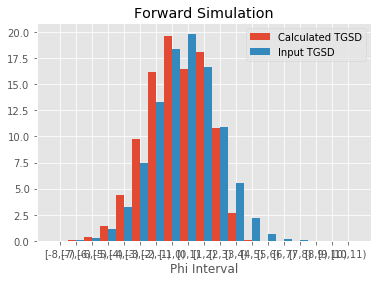

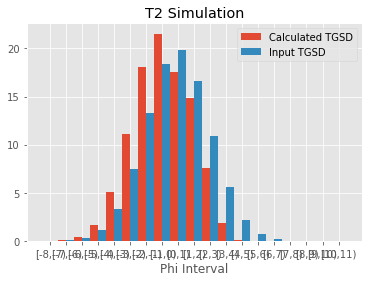

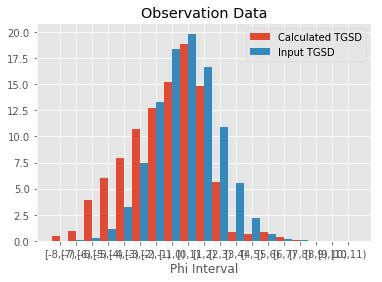

In [13]:
probs = np.array([phi["probability"] for phi in phi_steps])
x = np.array([phi["centroid"] for phi in phi_steps])
labels = [phi["interval"] for phi in phi_steps]

print(x)
fig, ax = plt.subplots()
ax.bar(x-0.25, forward_tgsd, width=0.5, align="center", label="Calculated TGSD")
ax.bar(x+0.25, np.array(probs)*100, width=0.5, align="center", label="Input TGSD")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.legend()
plt.title("Forward Simulation")
plt.show()



fig, ax = plt.subplots()
ax.bar(x-0.25, t2_tgsd, width=0.5, align="center", label="Calculated TGSD")
ax.bar(x+0.25, np.array(probs)*100, width=0.5, align="center", label="Input TGSD")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.legend()
plt.title("T2 Simulation")
plt.show()

fig, ax = plt.subplots()
ax.bar(x-0.25, obs_tgsd, width=0.5, align="center", label="Calculated TGSD")
ax.bar(x+0.25, np.array(probs)*100, width=0.5, align="center", label="Input TGSD")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.legend()
plt.title("Observation Data")
plt.show()

    

In [15]:
H = 45000

def col_truncnorm(mean, top=45000):
    bottom = 5000
    std = (top - bottom)/4
    standard_a, standard_b = (bottom - mean) / std, (top - mean) / std
    return truncnorm.rvs(standard_a, standard_b, loc=mean, scale=std)

def lognorm(prior, bottom=0):
    std_norm = norm.rvs()
    std_lognorm = np.exp(std_norm)
    lognorm = bottom + (prior-bottom)*std_lognorm
    return lognorm

def normal(prior):
    std_norm = norm.rvs()
    normal = prior*std_norm
    return normal

def uninformed(bottom, top):
    unif = uniform.rvs(loc = bottom, scale = (top-bottom))
    return unif


,invert,sample_function,value
a,False,<function lognorm at 0x0000029FFFA9C378>,"[2, 1]"
b,False,<function lognorm at 0x0000029FFFA9C378>,"[2, 1]"
h1,True,<function col_truncnorm at 0x0000029FFFA9C598>,"[20000, 45000]"
u,False,<function normal at 0x0000029FFFA9C488>,[0.001]
v,False,<function normal at 0x0000029FFFA9C488>,[-0.001]
D,False,<function lognorm at 0x0000029FFFA9C378>,[92066.0]
ftt,False,<function lognorm at 0x0000029FFFA9C378>,[3600.0]
M,False,<function lognorm at 0x0000029FFFA9C378>,[250000000000.0]


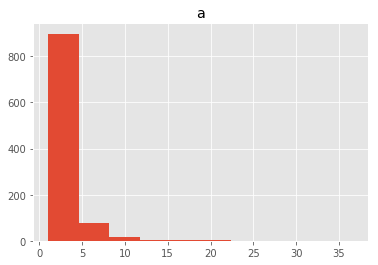

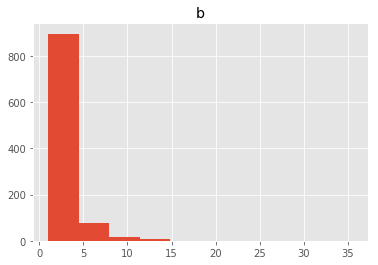

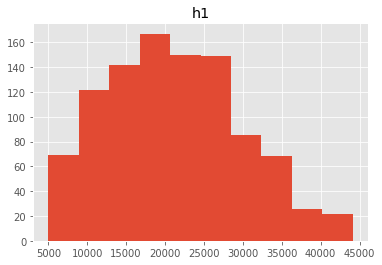

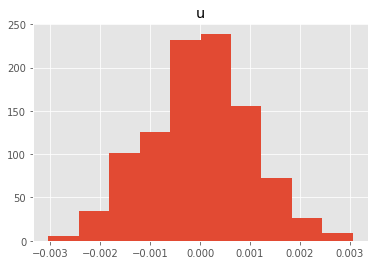

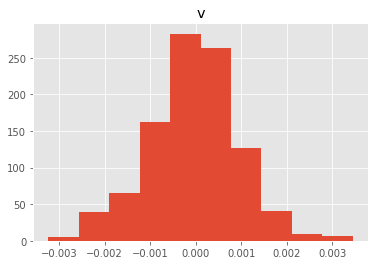

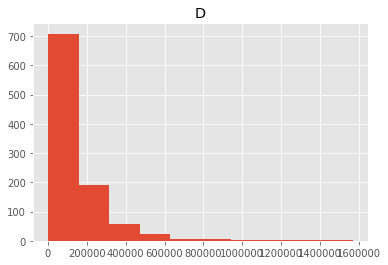

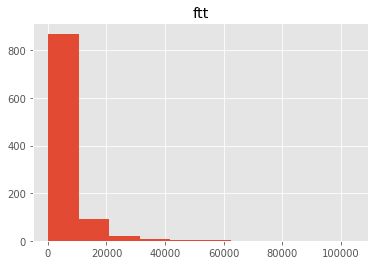

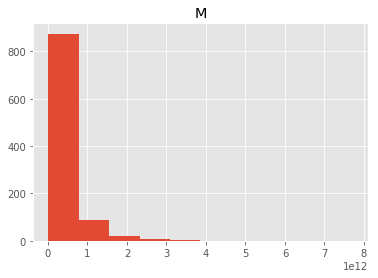

In [16]:
param_config = {
    "a": {
        "value":[2, 1],
        "invert":False,
        "sample_function": lognorm
    },
    "b": {
        "value":[2, 1],
        "invert":False,
        "sample_function": lognorm
    },
    "h1": {
        "value":[20000, H],
        "invert":True,
        "sample_function": col_truncnorm
    },
    "u": {
        "value":[1e-3],
        "invert":False,
        "sample_function": normal
    },
    "v": {
        "value":[-1e-3],
        "invert":False,
        "sample_function": normal
    },
    "D": {
        "value":[config["DIFFUSION_COEFFICIENT"]],
        "invert":False,
        "sample_function": lognorm
    },
    "ftt": {
        "value":[config["FALL_TIME_THRESHOLD"]],
        "invert":False,
        "sample_function": lognorm
    },
    "M": {
        "value":[config["ERUPTION_MASS"]],
        "invert":False,
        "sample_function": lognorm
    }
}
param_config_df = pd.DataFrame(param_config)
display(param_config_df.T)

for key, val in param_config.items():
    x = [val["sample_function"](*val["value"]) for i in range(1000)]
    plt.hist(x)
    plt.title(key)
    plt.show()

24831936.644731183
========[-8,-7)========
Run 0===========================================================================
2


C:\Users\nmostert\Documents\repos\inversion_project\utils.py:431: RuntimeWarning: invalid value encountered in true_divide
  ret = (plume/sum(plume))*tot_mass


a* = 0.00000	b* = 0.00000	            h1* = -0.82202	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.48042	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 11
SSE: 53145.53193746381


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"5,050.83","4,625.48"
u,0.001,0.001
v,-0.001,-0.001


Run 0 Time: 0.006 minutes


Estimated remaining run time: 0.114 minutes


Run 1===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.01995	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 18
SSE: 53145.53192245158


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"6,141.01","4,625.02"
u,0.001,0.001
v,-0.001,-0.001


Run 1 Time: 0.010 minutes


Estimated remaining run time: 0.188 minutes


Run 2===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.20876	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 13124.99911	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 30
SSE: 49050.26324354606


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"15,072","13,125"
u,0.001,0.001
v,-0.001,-0.001


Run 2 Time: 0.016 minutes


Estimated remaining run time: 0.279 minutes


Run 3===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.20876	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 13125.00041	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 32
SSE: 49050.263361985795


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"29,457.7","13,125"
u,0.001,0.001
v,-0.001,-0.001


Run 3 Time: 0.017 minutes


Estimated remaining run time: 0.279 minutes


Run 4===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.20876	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 13124.99847	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 33
SSE: 49050.26327270726


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"26,944.7","13,125"
u,0.001,0.001
v,-0.001,-0.001


Run 4 Time: 0.017 minutes


Estimated remaining run time: 0.258 minutes


Run 5===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.20876	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 13124.99807	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 34
SSE: 49050.26329133919


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"36,797.5","13,125"
u,0.001,0.001
v,-0.001,-0.001


Run 5 Time: 0.019 minutes


Estimated remaining run time: 0.266 minutes


Run 6===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.20876	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 13124.99875	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 33
SSE: 49050.26326000788


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"24,496.6","13,125"
u,0.001,0.001
v,-0.001,-0.001


Run 6 Time: 0.017 minutes


Estimated remaining run time: 0.227 minutes


Run 7===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.20876	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 13124.99848	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 27
SSE: 49050.26327249332


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"12,448.5","13,125"
u,0.001,0.001
v,-0.001,-0.001


Run 7 Time: 0.014 minutes


Estimated remaining run time: 0.166 minutes


Run 8===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.20876	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 13124.99739	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 27
SSE: 49050.263322290644


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"10,903.1","13,125"
u,0.001,0.001
v,-0.001,-0.001


Run 8 Time: 0.015 minutes


Estimated remaining run time: 0.163 minutes


Run 9===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.20876	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 13124.99868	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 34
SSE: 49050.263263039305


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"26,014.2","13,125"
u,0.001,0.001
v,-0.001,-0.001


Run 9 Time: 0.016 minutes


Estimated remaining run time: 0.164 minutes


Run 10===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.20876	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 13124.99880	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 27
SSE: 49050.26325747277


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"13,630","13,125"
u,0.001,0.001
v,-0.001,-0.001


Run 10 Time: 0.014 minutes


Estimated remaining run time: 0.122 minutes


Run 11===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.20876	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 13124.99885	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 31
SSE: 49050.26325523127


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,132.8","13,125"
u,0.001,0.001
v,-0.001,-0.001


Run 11 Time: 0.016 minutes


Estimated remaining run time: 0.127 minutes


Run 12===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82195	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.21314	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 15
SSE: 53145.53196135213


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"6,104.83","4,626.21"
u,0.001,0.001
v,-0.001,-0.001


Run 12 Time: 0.008 minutes


Estimated remaining run time: 0.053 minutes


Run 13===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.20876	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 13124.97962	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 32
SSE: 49050.26413758276


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"43,898.4","13,125"
u,0.001,0.001
v,-0.001,-0.001


Run 13 Time: 0.018 minutes


Estimated remaining run time: 0.106 minutes


Run 14===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.20876	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 13124.99856	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 33
SSE: 49050.26326865159


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"20,650.1","13,125"
u,0.001,0.001
v,-0.001,-0.001


Run 14 Time: 0.017 minutes


Estimated remaining run time: 0.087 minutes


Run 15===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.20876	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 13124.99963	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 34
SSE: 49050.26321978402


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"29,836.2","13,125"
u,0.001,0.001
v,-0.001,-0.001


Run 15 Time: 0.018 minutes


Estimated remaining run time: 0.072 minutes


Run 16===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.20876	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 13124.99872	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 31
SSE: 49050.26326118789


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"8,246.73","13,125"
u,0.001,0.001
v,-0.001,-0.001


Run 16 Time: 0.017 minutes


Estimated remaining run time: 0.052 minutes


Run 17===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.20876	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 13124.99779	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 34
SSE: 49050.26330380581


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,891.5","13,125"
u,0.001,0.001
v,-0.001,-0.001


Run 17 Time: 0.018 minutes


Estimated remaining run time: 0.036 minutes


Run 18===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.20876	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 13124.99942	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 35
SSE: 49050.26322937904


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"31,177.3","13,125"
u,0.001,0.001
v,-0.001,-0.001


Run 18 Time: 0.018 minutes


Estimated remaining run time: 0.018 minutes


Run 19===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.20876	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 13124.99931	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 36
SSE: 49050.263234202066


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"36,528.4","13,125"
u,0.001,0.001
v,-0.001,-0.001


Run 19 Time: 0.019 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.31224 minutes


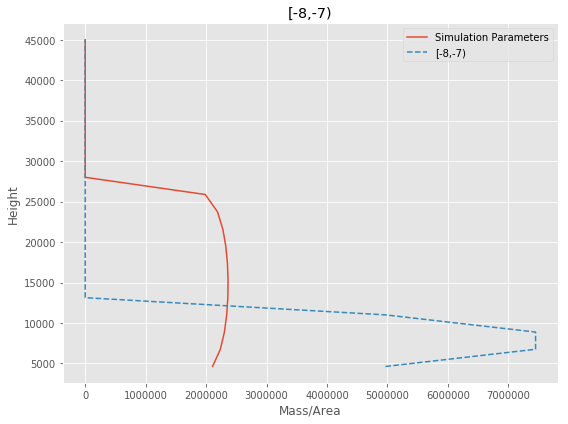

[-8,-7) Run Time: 0.31484 minutes


154027412.9346662
========[-7,-6)========
Run 0===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82205	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.11080	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 28
SSE: 1089.3491851147483


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"15,981.5","4,625.11"
u,0.001,0.001
v,-0.001,-0.001


Run 0 Time: 0.015 minutes


Estimated remaining run time: 0.292 minutes


Run 1===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82200	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.65487	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 1089.3491854783215


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"12,754.1","4,625.65"
u,0.001,0.001
v,-0.001,-0.001


Run 1 Time: 0.011 minutes


Estimated remaining run time: 0.206 minutes


Run 2===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82197	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.95871	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 1089.3491856813687


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"29,431.4","4,625.96"
u,0.001,0.001
v,-0.001,-0.001


Run 2 Time: 0.011 minutes


Estimated remaining run time: 0.190 minutes


Run 3===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82200	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.67398	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 1089.3491854910908


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"21,960.9","4,625.67"
u,0.001,0.001
v,-0.001,-0.001


Run 3 Time: 0.012 minutes


Estimated remaining run time: 0.188 minutes


Run 4===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00965	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 24
SSE: 1089.3491850471519


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"22,623.8","4,625.01"
u,0.001,0.001
v,-0.001,-0.001


Run 4 Time: 0.013 minutes


Estimated remaining run time: 0.195 minutes


Run 5===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82201	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.53369	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 21
SSE: 1089.3491853973405


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"7,716.2","4,625.53"
u,0.001,0.001
v,-0.001,-0.001


Run 5 Time: 0.011 minutes


Estimated remaining run time: 0.157 minutes


Run 6===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82194	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.30841	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 13
SSE: 1089.349185915065


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"5,082.14","4,626.31"
u,0.001,0.001
v,-0.001,-0.001


Run 6 Time: 0.008 minutes


Estimated remaining run time: 0.102 minutes


Run 7===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82204	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.21143	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 17
SSE: 1089.3491851819936


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"6,886.98","4,625.21"
u,0.001,0.001
v,-0.001,-0.001


Run 7 Time: 0.009 minutes


Estimated remaining run time: 0.106 minutes


Run 8===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82196	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.02457	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 22
SSE: 1089.3491857253805


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"13,647","4,626.02"
u,0.001,0.001
v,-0.001,-0.001


Run 8 Time: 0.012 minutes


Estimated remaining run time: 0.129 minutes


Run 9===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82196	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.10522	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 22
SSE: 1089.349185779278


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"11,631.5","4,626.11"
u,0.001,0.001
v,-0.001,-0.001


Run 9 Time: 0.011 minutes


Estimated remaining run time: 0.115 minutes


Run 10===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82202	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.44996	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 25
SSE: 1089.3491853413898


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"14,871.4","4,625.45"
u,0.001,0.001
v,-0.001,-0.001


Run 10 Time: 0.013 minutes


Estimated remaining run time: 0.117 minutes


Run 11===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82201	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.52492	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 24
SSE: 1089.3491853914852


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"14,267.3","4,625.52"
u,0.001,0.001
v,-0.001,-0.001


Run 11 Time: 0.012 minutes


Estimated remaining run time: 0.096 minutes


Run 12===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82197	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.96018	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 24
SSE: 1089.349185682351


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"18,129.1","4,625.96"
u,0.001,0.001
v,-0.001,-0.001


Run 12 Time: 0.013 minutes


Estimated remaining run time: 0.089 minutes


Run 13===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82201	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.56848	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 21
SSE: 1089.3491854205881


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"20,176.8","4,625.57"
u,0.001,0.001
v,-0.001,-0.001


Run 13 Time: 0.010 minutes


Estimated remaining run time: 0.062 minutes


Run 14===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82196	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.02101	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 21
SSE: 1089.349185723003


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"15,313.1","4,626.02"
u,0.001,0.001
v,-0.001,-0.001


Run 14 Time: 0.011 minutes


Estimated remaining run time: 0.055 minutes


Run 15===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82201	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.50667	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 24
SSE: 1089.349185379284


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"18,772.7","4,625.51"
u,0.001,0.001
v,-0.001,-0.001


Run 15 Time: 0.013 minutes


Estimated remaining run time: 0.050 minutes


Run 16===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82200	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.62844	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 21
SSE: 1089.3491854606575


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"20,578.6","4,625.63"
u,0.001,0.001
v,-0.001,-0.001


Run 16 Time: 0.011 minutes


Estimated remaining run time: 0.033 minutes


Run 17===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82197	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.99581	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 1089.349185706162


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"18,486.4","4,626"
u,0.001,0.001
v,-0.001,-0.001


Run 17 Time: 0.012 minutes


Estimated remaining run time: 0.023 minutes


Run 18===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82203	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.38291	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 38
SSE: 1089.3491852965833


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"16,554.4","4,625.38"
u,0.001,0.001
v,-0.001,-0.001


Run 18 Time: 0.020 minutes


Estimated remaining run time: 0.020 minutes


Run 19===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82205	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.16789	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 28
SSE: 1089.3491851528954


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"17,651.7","4,625.17"
u,0.001,0.001
v,-0.001,-0.001


Run 19 Time: 0.014 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.24193 minutes


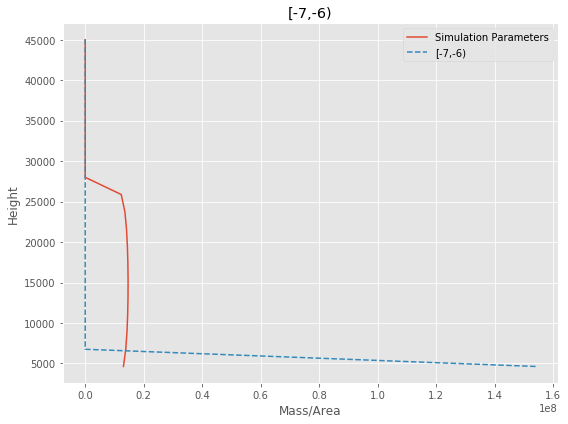

[-7,-6) Run Time: 0.24479 minutes


744066633.9933488
========[-6,-5)========
Run 0===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82205	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.16888	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 24
SSE: 184.33557509959482


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"28,710.7","4,625.17"
u,0.001,0.001
v,-0.001,-0.001


Run 0 Time: 0.012 minutes


Estimated remaining run time: 0.233 minutes


Run 1===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.01750	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 184.33557508247685


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"15,268.4","4,625.02"
u,0.001,0.001
v,-0.001,-0.001


Run 1 Time: 0.011 minutes


Estimated remaining run time: 0.202 minutes


Run 2===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82203	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.34478	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 21
SSE: 184.33557511948524


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"10,808.4","4,625.34"
u,0.001,0.001
v,-0.001,-0.001


Run 2 Time: 0.011 minutes


Estimated remaining run time: 0.186 minutes


Run 3===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82196	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.06327	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 27
SSE: 184.33557520073242


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"40,512.1","4,626.06"
u,0.001,0.001
v,-0.001,-0.001


Run 3 Time: 0.013 minutes


Estimated remaining run time: 0.212 minutes


Run 4===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82205	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.08271	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 27
SSE: 184.33557508985012


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"17,002.5","4,625.08"
u,0.001,0.001
v,-0.001,-0.001


Run 4 Time: 0.014 minutes


Estimated remaining run time: 0.207 minutes


Run 5===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82198	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.90394	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 22
SSE: 184.33557518271513


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"13,032.1","4,625.9"
u,0.001,0.001
v,-0.001,-0.001


Run 5 Time: 0.012 minutes


Estimated remaining run time: 0.164 minutes


Run 6===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82199	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.78360	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 184.33557516910682


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"13,041.3","4,625.78"
u,0.001,0.001
v,-0.001,-0.001


Run 6 Time: 0.012 minutes


Estimated remaining run time: 0.156 minutes


Run 7===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00098	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 18
SSE: 184.33557508060863


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"6,955.77","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 7 Time: 0.009 minutes


Estimated remaining run time: 0.109 minutes


Run 8===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82197	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.99267	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 26
SSE: 184.33557519274876


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"18,527.5","4,625.99"
u,0.001,0.001
v,-0.001,-0.001


Run 8 Time: 0.014 minutes


Estimated remaining run time: 0.152 minutes


Run 9===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82198	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.83475	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 184.33557517489075


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"12,913.9","4,625.83"
u,0.001,0.001
v,-0.001,-0.001


Run 9 Time: 0.011 minutes


Estimated remaining run time: 0.115 minutes


Run 10===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82198	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.82149	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 24
SSE: 184.33557517339142


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"21,515.4","4,625.82"
u,0.001,0.001
v,-0.001,-0.001


Run 10 Time: 0.013 minutes


Estimated remaining run time: 0.113 minutes


Run 11===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82198	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.83855	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 184.33557517532086


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"29,628.1","4,625.84"
u,0.001,0.001
v,-0.001,-0.001


Run 11 Time: 0.012 minutes


Estimated remaining run time: 0.096 minutes


Run 12===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82191	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.57403	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 24
SSE: 184.33557525849082


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"18,624.2","4,626.57"
u,0.001,0.001
v,-0.001,-0.001


Run 12 Time: 0.013 minutes


Estimated remaining run time: 0.091 minutes


Run 13===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82202	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.42241	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 26
SSE: 184.33557512826295


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"38,435.4","4,625.42"
u,0.001,0.001
v,-0.001,-0.001


Run 13 Time: 0.014 minutes


Estimated remaining run time: 0.086 minutes


Run 14===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82204	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.21762	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 184.33557510510573


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"14,967.2","4,625.22"
u,0.001,0.001
v,-0.001,-0.001


Run 14 Time: 0.012 minutes


Estimated remaining run time: 0.059 minutes


Run 15===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82204	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.20395	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 26
SSE: 184.3355751035602


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"26,826.4","4,625.2"
u,0.001,0.001
v,-0.001,-0.001


Run 15 Time: 0.014 minutes


Estimated remaining run time: 0.054 minutes


Run 16===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82197	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.94379	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 22
SSE: 184.3355751872205


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"38,933.1","4,625.94"
u,0.001,0.001
v,-0.001,-0.001


Run 16 Time: 0.012 minutes


Estimated remaining run time: 0.037 minutes


Run 17===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82205	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.16297	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 27
SSE: 184.33557509892603


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,180.4","4,625.16"
u,0.001,0.001
v,-0.001,-0.001


Run 17 Time: 0.014 minutes


Estimated remaining run time: 0.028 minutes


Run 18===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82199	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.78638	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 26
SSE: 184.33557516942125


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"18,828.9","4,625.79"
u,0.001,0.001
v,-0.001,-0.001


Run 18 Time: 0.014 minutes


Estimated remaining run time: 0.014 minutes


Run 19===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82196	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.05910	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 26
SSE: 184.3355752002601


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"40,336.3","4,626.06"
u,0.001,0.001
v,-0.001,-0.001


Run 19 Time: 0.014 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.24974 minutes


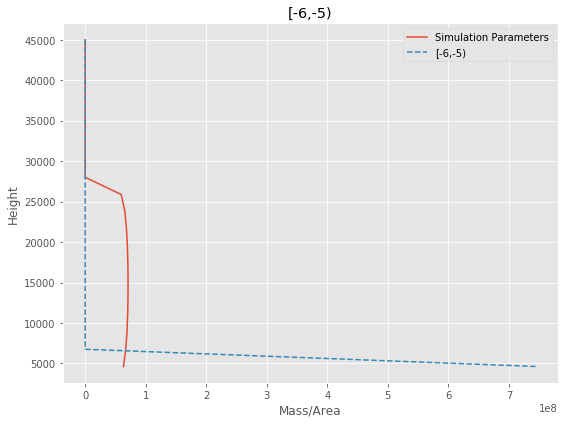

[-6,-5) Run Time: 0.25234 minutes


2799316593.5538564
========[-5,-4)========
Run 0===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82205	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.12389	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 25
SSE: 9.223651107165164


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"31,288.8","4,625.12"
u,0.001,0.001
v,-0.001,-0.001


Run 0 Time: 0.014 minutes


Estimated remaining run time: 0.267 minutes


Run 1===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82199	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.75864	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 9.223651110756672


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"21,126.4","4,625.76"
u,0.001,0.001
v,-0.001,-0.001


Run 1 Time: 0.012 minutes


Estimated remaining run time: 0.220 minutes


Run 2===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82200	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.66543	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 27
SSE: 9.22365111022926


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"17,360.1","4,625.67"
u,0.001,0.001
v,-0.001,-0.001


Run 2 Time: 0.014 minutes


Estimated remaining run time: 0.235 minutes


Run 3===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82197	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.95760	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 26
SSE: 9.223651111882491


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"20,977.6","4,625.96"
u,0.001,0.001
v,-0.001,-0.001


Run 3 Time: 0.014 minutes


Estimated remaining run time: 0.221 minutes


Run 4===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82195	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.18757	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 26
SSE: 9.223651113183726


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"42,599.8","4,626.19"
u,0.001,0.001
v,-0.001,-0.001


Run 4 Time: 0.013 minutes


Estimated remaining run time: 0.199 minutes


Run 5===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82201	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.59387	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 25
SSE: 9.223651109824381


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"27,254.8","4,625.59"
u,0.001,0.001
v,-0.001,-0.001


Run 5 Time: 0.013 minutes


Estimated remaining run time: 0.186 minutes


Run 6===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82193	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.36202	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 22
SSE: 9.223651114170835


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"36,460.8","4,626.36"
u,0.001,0.001
v,-0.001,-0.001


Run 6 Time: 0.011 minutes


Estimated remaining run time: 0.142 minutes


Run 7===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82192	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.48760	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 25
SSE: 9.223651114881406


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"22,623.9","4,626.49"
u,0.001,0.001
v,-0.001,-0.001


Run 7 Time: 0.012 minutes


Estimated remaining run time: 0.147 minutes


Run 8===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82201	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.55854	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 9.22365110962447


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"13,665.1","4,625.56"
u,0.001,0.001
v,-0.001,-0.001


Run 8 Time: 0.013 minutes


Estimated remaining run time: 0.138 minutes


Run 9===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82196	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.08554	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 24
SSE: 9.223651112606378


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"25,301.5","4,626.09"
u,0.001,0.001
v,-0.001,-0.001


Run 9 Time: 0.013 minutes


Estimated remaining run time: 0.125 minutes


Run 10===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82199	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.74008	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 20
SSE: 9.223651110651655


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"9,600.1","4,625.74"
u,0.001,0.001
v,-0.001,-0.001


Run 10 Time: 0.010 minutes


Estimated remaining run time: 0.094 minutes


Run 11===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82198	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.90532	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 25
SSE: 9.223651111586666


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"20,991","4,625.91"
u,0.001,0.001
v,-0.001,-0.001


Run 11 Time: 0.014 minutes


Estimated remaining run time: 0.110 minutes


Run 12===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82195	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.17252	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 24
SSE: 9.223651113098555


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"13,745.5","4,626.17"
u,0.001,0.001
v,-0.001,-0.001


Run 12 Time: 0.013 minutes


Estimated remaining run time: 0.091 minutes


Run 13===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82200	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.66683	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 9.2236511102372


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"13,841.1","4,625.67"
u,0.001,0.001
v,-0.001,-0.001


Run 13 Time: 0.012 minutes


Estimated remaining run time: 0.072 minutes


Run 14===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82198	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.87732	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 9.223651111428188


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,902.8","4,625.88"
u,0.001,0.001
v,-0.001,-0.001


Run 14 Time: 0.011 minutes


Estimated remaining run time: 0.057 minutes


Run 15===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82203	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.35345	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 26
SSE: 9.223651108464063


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"22,912.2","4,625.35"
u,0.001,0.001
v,-0.001,-0.001


Run 15 Time: 0.014 minutes


Estimated remaining run time: 0.055 minutes


Run 16===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82199	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.70868	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 22
SSE: 9.223651110474032


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"12,455.1","4,625.71"
u,0.001,0.001
v,-0.001,-0.001


Run 16 Time: 0.011 minutes


Estimated remaining run time: 0.034 minutes


Run 17===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.03658	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 26
SSE: 9.223651106671165


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"29,096.4","4,625.04"
u,0.001,0.001
v,-0.001,-0.001


Run 17 Time: 0.014 minutes


Estimated remaining run time: 0.028 minutes


Run 18===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82204	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.19052	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 25
SSE: 9.223651107542183


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"29,073.4","4,625.19"
u,0.001,0.001
v,-0.001,-0.001


Run 18 Time: 0.013 minutes


Estimated remaining run time: 0.013 minutes


Run 19===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82196	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.04188	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 24
SSE: 9.223651112359343


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"22,320.5","4,626.04"
u,0.001,0.001
v,-0.001,-0.001


Run 19 Time: 0.012 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.25339 minutes


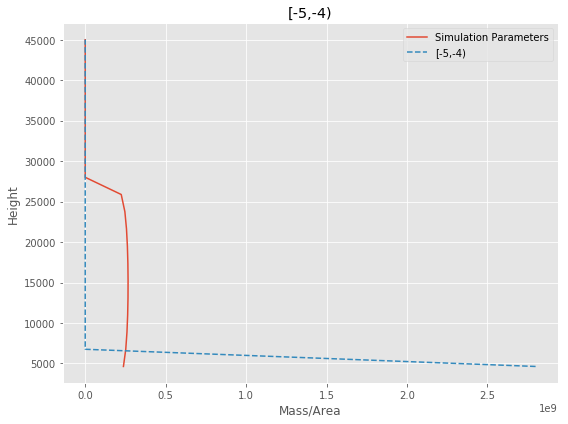

[-5,-4) Run Time: 0.25651 minutes


8201977745.458983
========[-4,-3)========
Run 0===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82196	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.11692	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 24
SSE: 1.1070383085121405


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"11,638.3","4,626.12"
u,0.001,0.001
v,-0.001,-0.001


Run 0 Time: 0.013 minutes


Estimated remaining run time: 0.247 minutes


Run 1===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82196	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.06555	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 27
SSE: 1.1070383084772561


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"18,818.8","4,626.07"
u,0.001,0.001
v,-0.001,-0.001


Run 1 Time: 0.014 minutes


Estimated remaining run time: 0.248 minutes


Run 2===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82200	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.67205	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 21
SSE: 1.1070383082100252


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"29,754.8","4,625.67"
u,0.001,0.001
v,-0.001,-0.001


Run 2 Time: 0.011 minutes


Estimated remaining run time: 0.186 minutes


Run 3===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82199	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.70934	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 27
SSE: 1.107038308235345


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,648.1","4,625.71"
u,0.001,0.001
v,-0.001,-0.001


Run 3 Time: 0.014 minutes


Estimated remaining run time: 0.225 minutes


Run 4===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.01500	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 25
SSE: 1.10703830776382


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"30,657.4","4,625.02"
u,0.001,0.001
v,-0.001,-0.001


Run 4 Time: 0.013 minutes


Estimated remaining run time: 0.195 minutes


Run 5===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82188	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.94245	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 25
SSE: 1.1070383090727938


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"20,717.1","4,626.94"
u,0.001,0.001
v,-0.001,-0.001


Run 5 Time: 0.013 minutes


Estimated remaining run time: 0.179 minutes


Run 6===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82197	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.00117	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 26
SSE: 1.1070383084335316


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"40,978.8","4,626"
u,0.001,0.001
v,-0.001,-0.001


Run 6 Time: 0.014 minutes


Estimated remaining run time: 0.179 minutes


Run 7===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82196	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.11426	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 24
SSE: 1.1070383085103346


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,182.8","4,626.11"
u,0.001,0.001
v,-0.001,-0.001


Run 7 Time: 0.013 minutes


Estimated remaining run time: 0.156 minutes


Run 8===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82201	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.53687	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 28
SSE: 1.107038308118218


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,333.8","4,625.54"
u,0.001,0.001
v,-0.001,-0.001


Run 8 Time: 0.015 minutes


Estimated remaining run time: 0.169 minutes


Run 9===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82203	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.28471	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 25
SSE: 1.10703830794698


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"25,348.9","4,625.28"
u,0.001,0.001
v,-0.001,-0.001


Run 9 Time: 0.013 minutes


Estimated remaining run time: 0.133 minutes


Run 10===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82201	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.59421	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 26
SSE: 1.1070383081571609


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"40,134.1","4,625.59"
u,0.001,0.001
v,-0.001,-0.001


Run 10 Time: 0.014 minutes


Estimated remaining run time: 0.129 minutes


Run 11===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82194	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.28012	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 1.107038308622977


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"39,535.6","4,626.28"
u,0.001,0.001
v,-0.001,-0.001


Run 11 Time: 0.012 minutes


Estimated remaining run time: 0.096 minutes


Run 12===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82205	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.13706	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 26
SSE: 1.1070383078467123


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"17,964.7","4,625.14"
u,0.001,0.001
v,-0.001,-0.001


Run 12 Time: 0.014 minutes


Estimated remaining run time: 0.095 minutes


Run 13===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82197	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.97124	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 26
SSE: 1.107038308413207


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"37,721","4,625.97"
u,0.001,0.001
v,-0.001,-0.001


Run 13 Time: 0.014 minutes


Estimated remaining run time: 0.086 minutes


Run 14===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.05727	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 25
SSE: 1.1070383077925277


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"22,548","4,625.06"
u,0.001,0.001
v,-0.001,-0.001


Run 14 Time: 0.014 minutes


Estimated remaining run time: 0.072 minutes


Run 15===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82205	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.09793	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 25
SSE: 1.107038307820139


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"27,160.2","4,625.1"
u,0.001,0.001
v,-0.001,-0.001


Run 15 Time: 0.014 minutes


Estimated remaining run time: 0.055 minutes


Run 16===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82194	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.23406	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 26
SSE: 1.1070383085916993


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"26,140.9","4,626.23"
u,0.001,0.001
v,-0.001,-0.001


Run 16 Time: 0.014 minutes


Estimated remaining run time: 0.042 minutes


Run 17===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82205	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.11969	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 1.1070383078349157


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"12,699.8","4,625.12"
u,0.001,0.001
v,-0.001,-0.001


Run 17 Time: 0.016 minutes


Estimated remaining run time: 0.031 minutes


Run 18===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82201	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.58882	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 22
SSE: 1.1070383081535033


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"37,006.9","4,625.59"
u,0.001,0.001
v,-0.001,-0.001


Run 18 Time: 0.013 minutes


Estimated remaining run time: 0.013 minutes


Run 19===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82201	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.58446	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 1.1070383081505386


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"22,553.7","4,625.58"
u,0.001,0.001
v,-0.001,-0.001


Run 19 Time: 0.012 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.27005 minutes


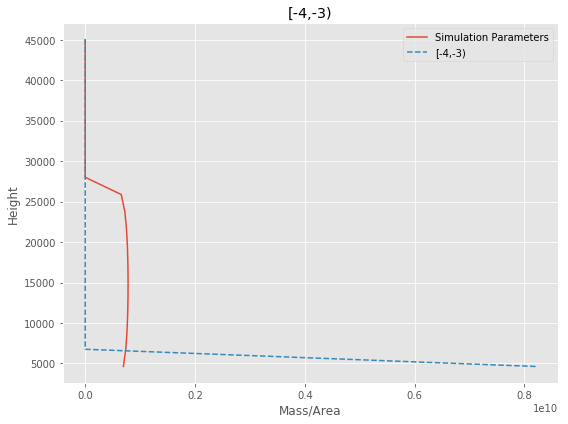

[-4,-3) Run Time: 0.27292 minutes


18715935255.021866
========[-3,-2)========
Run 0===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.47604	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 8997.75834	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 18
SSE: 0.22852234360120624


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"29,880.9","8,997.76"
u,0.001,0.001
v,-0.001,-0.001


Run 0 Time: 0.010 minutes


Estimated remaining run time: 0.183 minutes


Run 1===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.47597	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 8998.83157	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 18
SSE: 0.228522343357702


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"30,762.9","8,998.83"
u,0.001,0.001
v,-0.001,-0.001


Run 1 Time: 0.010 minutes


Estimated remaining run time: 0.173 minutes


Run 2===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.47599	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 8998.42126	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 19
SSE: 0.22852234226474158


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"32,073","8,998.42"
u,0.001,0.001
v,-0.001,-0.001


Run 2 Time: 0.010 minutes


Estimated remaining run time: 0.164 minutes


Run 3===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.47602	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 8998.02072	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 18
SSE: 0.22852234261354645


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"27,772.2","8,998.02"
u,0.001,0.001
v,-0.001,-0.001


Run 3 Time: 0.010 minutes


Estimated remaining run time: 0.154 minutes


Run 4===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.47598	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 8998.57253	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 17
SSE: 0.2285223424969824


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"14,293.3","8,998.57"
u,0.001,0.001
v,-0.001,-0.001


Run 4 Time: 0.010 minutes


Estimated remaining run time: 0.145 minutes


Run 5===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.47604	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 8997.80478	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 16
SSE: 0.22852234338256672


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"13,452.8","8,997.8"
u,0.001,0.001
v,-0.001,-0.001


Run 5 Time: 0.008 minutes


Estimated remaining run time: 0.117 minutes


Run 6===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.47599	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 8998.48733	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 19
SSE: 0.2285223423416468


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"24,801.5","8,998.49"
u,0.001,0.001
v,-0.001,-0.001


Run 6 Time: 0.010 minutes


Estimated remaining run time: 0.125 minutes


Run 7===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.47598	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 8998.58962	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 19
SSE: 0.22852234253576154


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"27,014.1","8,998.59"
u,0.001,0.001
v,-0.001,-0.001


Run 7 Time: 0.010 minutes


Estimated remaining run time: 0.125 minutes


Run 8===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.47599	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 8998.43192	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 18
SSE: 0.22852234227458318


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"27,517.3","8,998.43"
u,0.001,0.001
v,-0.001,-0.001


Run 8 Time: 0.010 minutes


Estimated remaining run time: 0.112 minutes


Run 9===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.47596	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 8998.85949	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 18
SSE: 0.22852234348537168


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"29,192.3","8,998.86"
u,0.001,0.001
v,-0.001,-0.001


Run 9 Time: 0.009 minutes


Estimated remaining run time: 0.091 minutes


Run 10===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.47598	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 8998.66786	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 18
SSE: 0.22852234274578517


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"29,143.7","8,998.67"
u,0.001,0.001
v,-0.001,-0.001


Run 10 Time: 0.009 minutes


Estimated remaining run time: 0.084 minutes


Run 11===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.47603	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 8997.92135	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 19
SSE: 0.22852234291684814


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"34,702.7","8,997.92"
u,0.001,0.001
v,-0.001,-0.001


Run 11 Time: 0.011 minutes


Estimated remaining run time: 0.085 minutes


Run 12===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.47601	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 8998.21872	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 17
SSE: 0.22852234226618065


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"14,775.1","8,998.22"
u,0.001,0.001
v,-0.001,-0.001


Run 12 Time: 0.009 minutes


Estimated remaining run time: 0.064 minutes


Run 13===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.47602	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 8998.00804	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 10
SSE: 0.228522342647449


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"9,523.96","8,998.01"
u,0.001,0.001
v,-0.001,-0.001


Run 13 Time: 0.005 minutes


Estimated remaining run time: 0.033 minutes


Run 14===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.47602	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 8998.01203	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 19
SSE: 0.2285223426366269


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"20,970.5","8,998.01"
u,0.001,0.001
v,-0.001,-0.001


Run 14 Time: 0.009 minutes


Estimated remaining run time: 0.044 minutes


Run 15===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.47601	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 8998.19924	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 18
SSE: 0.22852234228517995


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"26,381","8,998.2"
u,0.001,0.001
v,-0.001,-0.001


Run 15 Time: 0.009 minutes


Estimated remaining run time: 0.034 minutes


Run 16===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.47602	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 8998.03012	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 17
SSE: 0.22852234258930676


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"14,385","8,998.03"
u,0.001,0.001
v,-0.001,-0.001


Run 16 Time: 0.008 minutes


Estimated remaining run time: 0.025 minutes


Run 17===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.47602	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 8998.08223	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 19
SSE: 0.22852234246899078


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"18,070.9","8,998.08"
u,0.001,0.001
v,-0.001,-0.001


Run 17 Time: 0.009 minutes


Estimated remaining run time: 0.018 minutes


Run 18===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.47596	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 8998.96220	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 19
SSE: 0.22852234401333452


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"16,043.4","8,998.96"
u,0.001,0.001
v,-0.001,-0.001


Run 18 Time: 0.010 minutes


Estimated remaining run time: 0.010 minutes


Run 19===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.47602	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 8998.05606	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 21
SSE: 0.2285223425264663


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"16,251.5","8,998.06"
u,0.001,0.001
v,-0.001,-0.001


Run 19 Time: 0.010 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.18516 minutes


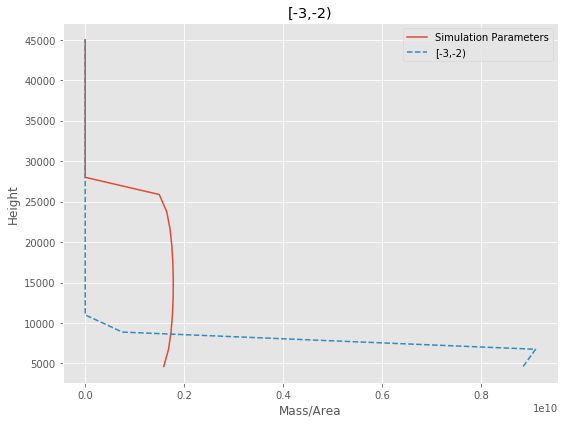

[-3,-2) Run Time: 0.18724 minutes


33260659881.446026
========[-2,-1)========
Run 0===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 0.60360	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 26044.91213	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 20
SSE: 0.14916907973215668


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"17,169.4","26,044.9"
u,0.001,0.001
v,-0.001,-0.001


Run 0 Time: 0.009 minutes


Estimated remaining run time: 0.173 minutes


Run 1===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 0.60359	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 26044.80641	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 15
SSE: 0.1491690797162425


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"22,322.3","26,044.8"
u,0.001,0.001
v,-0.001,-0.001


Run 1 Time: 0.007 minutes


Estimated remaining run time: 0.127 minutes


Run 2===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 0.60360	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 26044.87532	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 21
SSE: 0.14916907972603263


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"16,322.3","26,044.9"
u,0.001,0.001
v,-0.001,-0.001


Run 2 Time: 0.010 minutes


Estimated remaining run time: 0.168 minutes


Run 3===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 0.60357	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 26044.49437	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 14
SSE: 0.1491690796991854


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"29,465.8","26,044.5"
u,0.001,0.001
v,-0.001,-0.001


Run 3 Time: 0.007 minutes


Estimated remaining run time: 0.108 minutes


Run 4===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 0.60355	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 26044.26228	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 13
SSE: 0.14916907971548227


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"23,532.1","26,044.3"
u,0.001,0.001
v,-0.001,-0.001


Run 4 Time: 0.006 minutes


Estimated remaining run time: 0.090 minutes


Run 5===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 0.60360	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 26044.86018	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 19
SSE: 0.14916907972369547


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"11,498.5","26,044.9"
u,0.001,0.001
v,-0.001,-0.001


Run 5 Time: 0.009 minutes


Estimated remaining run time: 0.124 minutes


Run 6===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 0.60357	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 26044.53957	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 12
SSE: 0.14916907969888826


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"24,803.1","26,044.5"
u,0.001,0.001
v,-0.001,-0.001


Run 6 Time: 0.006 minutes


Estimated remaining run time: 0.074 minutes


Run 7===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 0.60357	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 26044.45827	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 20
SSE: 0.1491690797000966


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"14,366.7","26,044.5"
u,0.001,0.001
v,-0.001,-0.001


Run 7 Time: 0.010 minutes


Estimated remaining run time: 0.116 minutes


Run 8===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 0.60353	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 26043.98599	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 13
SSE: 0.14916907976712768


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"23,415.1","26,044"
u,0.001,0.001
v,-0.001,-0.001


Run 8 Time: 0.006 minutes


Estimated remaining run time: 0.069 minutes


Run 9===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 0.60357	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 26044.51681	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 12
SSE: 0.14916907969892065


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"26,926","26,044.5"
u,0.001,0.001
v,-0.001,-0.001


Run 9 Time: 0.006 minutes


Estimated remaining run time: 0.057 minutes


Run 10===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 0.60357	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 26044.56126	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 16
SSE: 0.1491690796990786


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"33,217.9","26,044.6"
u,0.001,0.001
v,-0.001,-0.001


Run 10 Time: 0.008 minutes


Estimated remaining run time: 0.068 minutes


Run 11===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 0.60358	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 26044.69142	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 17
SSE: 0.14916907970475687


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"37,575.3","26,044.7"
u,0.001,0.001
v,-0.001,-0.001


Run 11 Time: 0.008 minutes


Estimated remaining run time: 0.062 minutes


Run 12===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 0.60356	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 26044.35999	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 19
SSE: 0.1491690797056073


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"11,842.4","26,044.4"
u,0.001,0.001
v,-0.001,-0.001


Run 12 Time: 0.009 minutes


Estimated remaining run time: 0.062 minutes


Run 13===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 0.60359	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 26044.73078	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 14
SSE: 0.14916907970800494


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"31,124.4","26,044.7"
u,0.001,0.001
v,-0.001,-0.001


Run 13 Time: 0.007 minutes


Estimated remaining run time: 0.041 minutes


Run 14===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 0.60360	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 26044.98890	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 17
SSE: 0.14916907974692717


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,355.2","26,045"
u,0.001,0.001
v,-0.001,-0.001


Run 14 Time: 0.008 minutes


Estimated remaining run time: 0.042 minutes


Run 15===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 0.60359	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 26044.76342	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 19
SSE: 0.14916907971123855


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"17,762.6","26,044.8"
u,0.001,0.001
v,-0.001,-0.001


Run 15 Time: 0.009 minutes


Estimated remaining run time: 0.036 minutes


Run 16===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 0.60359	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 26044.83196	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 18
SSE: 0.1491690797196182


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"10,541.8","26,044.8"
u,0.001,0.001
v,-0.001,-0.001


Run 16 Time: 0.008 minutes


Estimated remaining run time: 0.025 minutes


Run 17===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 0.60356	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 26044.28766	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 18
SSE: 0.1491690797124956


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"18,784.5","26,044.3"
u,0.001,0.001
v,-0.001,-0.001


Run 17 Time: 0.009 minutes


Estimated remaining run time: 0.017 minutes


Run 18===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 0.60358	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 26044.60840	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 16
SSE: 0.1491690797002372


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"31,858.3","26,044.6"
u,0.001,0.001
v,-0.001,-0.001


Run 18 Time: 0.008 minutes


Estimated remaining run time: 0.008 minutes


Run 19===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 0.60355	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 26044.18987	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 14
SSE: 0.14916907972562835


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"30,451.5","26,044.2"
u,0.001,0.001
v,-0.001,-0.001


Run 19 Time: 0.007 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.15495 minutes


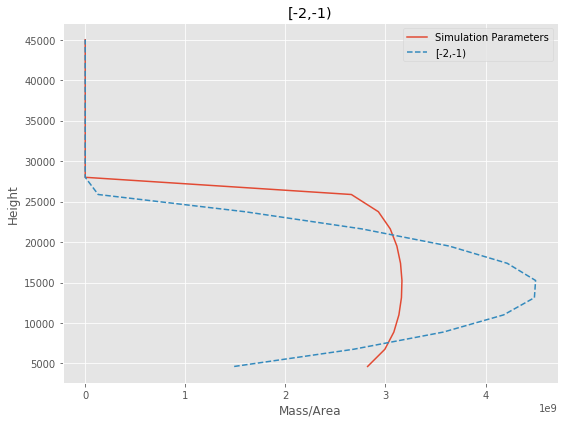

[-2,-1) Run Time: 0.15703 minutes


46033772581.463806
========[-1,0)========
Run 0===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 1.14698	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 32755.36596	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 14
SSE: 0.13567109966561244


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"29,164.9","32,755.4"
u,0.001,0.001
v,-0.001,-0.001


Run 0 Time: 0.007 minutes


Estimated remaining run time: 0.129 minutes


Run 1===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 1.14694	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 32754.96342	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 22
SSE: 0.1356710996982231


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"17,029.4","32,755"
u,0.001,0.001
v,-0.001,-0.001


Run 1 Time: 0.011 minutes


Estimated remaining run time: 0.192 minutes


Run 2===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 1.14697	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 32755.32981	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 17
SSE: 0.1356710996663617


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"23,682.4","32,755.3"
u,0.001,0.001
v,-0.001,-0.001


Run 2 Time: 0.008 minutes


Estimated remaining run time: 0.137 minutes


Run 3===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 1.14696	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 32755.15928	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 15
SSE: 0.13567109967569568


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"27,902.4","32,755.2"
u,0.001,0.001
v,-0.001,-0.001


Run 3 Time: 0.007 minutes


Estimated remaining run time: 0.108 minutes


Run 4===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 1.14697	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 32755.26309	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 16
SSE: 0.1356710996688739


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"26,917.3","32,755.3"
u,0.001,0.001
v,-0.001,-0.001


Run 4 Time: 0.008 minutes


Estimated remaining run time: 0.125 minutes


Run 5===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 1.14698	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 32755.45709	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 15
SSE: 0.13567109966563173


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"27,934.9","32,755.5"
u,0.001,0.001
v,-0.001,-0.001


Run 5 Time: 0.007 minutes


Estimated remaining run time: 0.095 minutes


Run 6===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 1.14698	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 32755.37553	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 15
SSE: 0.135671099665486


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"38,408.9","32,755.4"
u,0.001,0.001
v,-0.001,-0.001


Run 6 Time: 0.007 minutes


Estimated remaining run time: 0.095 minutes


Run 7===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82199	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.79918	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 18
SSE: 0.3286263259687831


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"6,662.73","4,625.8"
u,0.001,0.001
v,-0.001,-0.001


Run 7 Time: 0.008 minutes


Estimated remaining run time: 0.100 minutes


Run 8===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 1.14699	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 32755.49690	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 21
SSE: 0.13567109966649782


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"17,993.7","32,755.5"
u,0.001,0.001
v,-0.001,-0.001


Run 8 Time: 0.010 minutes


Estimated remaining run time: 0.112 minutes


Run 9===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 1.14699	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 32755.47992	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 17
SSE: 0.1356710996660647


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"25,354.6","32,755.5"
u,0.001,0.001
v,-0.001,-0.001


Run 9 Time: 0.008 minutes


Estimated remaining run time: 0.078 minutes


Run 10===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 1.14697	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 32755.32383	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 12
SSE: 0.13567109966652718


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"31,505.7","32,755.3"
u,0.001,0.001
v,-0.001,-0.001


Run 10 Time: 0.005 minutes


Estimated remaining run time: 0.049 minutes


Run 11===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 1.14698	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 32755.43038	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 16
SSE: 0.135671099665343


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"26,209.9","32,755.4"
u,0.001,0.001
v,-0.001,-0.001


Run 11 Time: 0.007 minutes


Estimated remaining run time: 0.058 minutes


Run 12===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.00017	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 16551.72190	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 1
SSE: 0.18771271541484832


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"16,551.7","16,551.7"
u,0.001,0.001
v,-0.001,-0.001


Run 12 Time: 0.001 minutes


Estimated remaining run time: 0.009 minutes


Run 13===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 1.14700	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 32755.64518	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 20
SSE: 0.13567109967431165


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,395.1","32,755.6"
u,0.001,0.001
v,-0.001,-0.001


Run 13 Time: 0.009 minutes


Estimated remaining run time: 0.056 minutes


Run 14===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 1.14697	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 32755.25899	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 17
SSE: 0.13567109966907587


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"25,652.5","32,755.3"
u,0.001,0.001
v,-0.001,-0.001


Run 14 Time: 0.008 minutes


Estimated remaining run time: 0.039 minutes


Run 15===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82201	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.50100	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 13
SSE: 0.32862632590867064


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"5,279","4,625.5"
u,0.001,0.001
v,-0.001,-0.001


Run 15 Time: 0.007 minutes


Estimated remaining run time: 0.026 minutes


Run 16===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 1.14695	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 32755.12835	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 0.13567109967841318


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"16,793.6","32,755.1"
u,0.001,0.001
v,-0.001,-0.001


Run 16 Time: 0.011 minutes


Estimated remaining run time: 0.033 minutes


Run 17===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 1.14701	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 32755.68076	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 20
SSE: 0.13567109967726285


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"18,648.2","32,755.7"
u,0.001,0.001
v,-0.001,-0.001


Run 17 Time: 0.009 minutes


Estimated remaining run time: 0.018 minutes


Run 18===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 1.14697	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 32755.26406	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 13
SSE: 0.13567109966882665


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"34,502.2","32,755.3"
u,0.001,0.001
v,-0.001,-0.001


Run 18 Time: 0.007 minutes


Estimated remaining run time: 0.007 minutes


Run 19===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 1.14699	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 32755.48375	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 12
SSE: 0.13567109966615393


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"33,380.5","32,755.5"
u,0.001,0.001
v,-0.001,-0.001


Run 19 Time: 0.005 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.15078 minutes


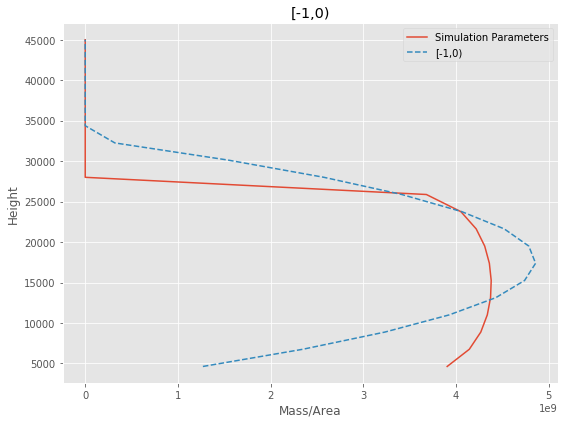

[-1,0) Run Time: 0.15286 minutes


49619073870.98735
========[0,1)========
Run 0===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.07095	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 15381.02526	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 16
SSE: 0.10639773132429371


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,963.8","15,381"
u,0.001,0.001
v,-0.001,-0.001


Run 0 Time: 0.007 minutes


Estimated remaining run time: 0.139 minutes


Run 1===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.07089	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 15382.08213	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 16
SSE: 0.1063977314863714


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"22,565.6","15,382.1"
u,0.001,0.001
v,-0.001,-0.001


Run 1 Time: 0.008 minutes


Estimated remaining run time: 0.136 minutes


Run 2===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.07094	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 15381.14385	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 16
SSE: 0.10639773116450764


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,099.3","15,381.1"
u,0.001,0.001
v,-0.001,-0.001


Run 2 Time: 0.008 minutes


Estimated remaining run time: 0.128 minutes


Run 3===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.07132	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 15
SSE: 0.19082515718291038


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"5,742.99","4,625.07"
u,0.001,0.001
v,-0.001,-0.001


Run 3 Time: 0.007 minutes


Estimated remaining run time: 0.117 minutes


Run 4===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.07093	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 15381.40429	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 16
SSE: 0.10639773097153382


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"24,111.1","15,381.4"
u,0.001,0.001
v,-0.001,-0.001


Run 4 Time: 0.008 minutes


Estimated remaining run time: 0.117 minutes


Run 5===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.07089	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 15382.03994	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 16
SSE: 0.10639773141145199


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,845.9","15,382"
u,0.001,0.001
v,-0.001,-0.001


Run 5 Time: 0.008 minutes


Estimated remaining run time: 0.106 minutes


Run 6===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.07093	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 15381.43982	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 16
SSE: 0.10639773096202991


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"16,833.5","15,381.4"
u,0.001,0.001
v,-0.001,-0.001


Run 6 Time: 0.008 minutes


Estimated remaining run time: 0.102 minutes


Run 7===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.07091	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 15381.62556	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 16
SSE: 0.10639773097807136


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"21,068.3","15,381.6"
u,0.001,0.001
v,-0.001,-0.001


Run 7 Time: 0.008 minutes


Estimated remaining run time: 0.094 minutes


Run 8===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.07090	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 15381.92960	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 16
SSE: 0.10639773124242331


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"23,389.1","15,381.9"
u,0.001,0.001
v,-0.001,-0.001


Run 8 Time: 0.008 minutes


Estimated remaining run time: 0.083 minutes


Run 9===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.07089	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 15382.05324	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 16
SSE: 0.10639773143445894


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"22,968","15,382.1"
u,0.001,0.001
v,-0.001,-0.001


Run 9 Time: 0.008 minutes


Estimated remaining run time: 0.076 minutes


Run 10===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.73782	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44855.25234	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 21
SSE: 0.14732713316516435


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"35,476.1","44,855.3"
u,0.001,0.001
v,-0.001,-0.001


Run 10 Time: 0.010 minutes


Estimated remaining run time: 0.091 minutes


Run 11===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.07094	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 15381.24991	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 16
SSE: 0.10639773105972672


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"24,262.3","15,381.2"
u,0.001,0.001
v,-0.001,-0.001


Run 11 Time: 0.007 minutes


Estimated remaining run time: 0.058 minutes


Run 12===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.07090	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 15381.89363	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 17
SSE: 0.10639773119573435


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"28,616.5","15,381.9"
u,0.001,0.001
v,-0.001,-0.001


Run 12 Time: 0.008 minutes


Estimated remaining run time: 0.058 minutes


Run 13===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.07094	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 15381.20065	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 15
SSE: 0.1063977311039144


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"11,313.5","15,381.2"
u,0.001,0.001
v,-0.001,-0.001


Run 13 Time: 0.008 minutes


Estimated remaining run time: 0.045 minutes


Run 14===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.07097	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 15380.73533	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 17
SSE: 0.10639773190451131


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"31,144.5","15,380.7"
u,0.001,0.001
v,-0.001,-0.001


Run 14 Time: 0.008 minutes


Estimated remaining run time: 0.040 minutes


Run 15===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.07092	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 15381.49606	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 15
SSE: 0.10639773095523965


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"9,071.27","15,381.5"
u,0.001,0.001
v,-0.001,-0.001


Run 15 Time: 0.007 minutes


Estimated remaining run time: 0.027 minutes


Run 16===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.07095	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 15381.11007	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 15
SSE: 0.10639773120544219


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"9,060.13","15,381.1"
u,0.001,0.001
v,-0.001,-0.001


Run 16 Time: 0.007 minutes


Estimated remaining run time: 0.020 minutes


Run 17===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.07094	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 15381.19073	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 16
SSE: 0.10639773111375893


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"21,131.1","15,381.2"
u,0.001,0.001
v,-0.001,-0.001


Run 17 Time: 0.007 minutes


Estimated remaining run time: 0.015 minutes


Run 18===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.07093	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 15381.41197	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 15
SSE: 0.10639773096913795


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"10,254.6","15,381.4"
u,0.001,0.001
v,-0.001,-0.001


Run 18 Time: 0.007 minutes


Estimated remaining run time: 0.007 minutes


Run 19===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.07096	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 15380.82663	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 15
SSE: 0.1063977316927626


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"9,172.49","15,380.8"
u,0.001,0.001
v,-0.001,-0.001


Run 19 Time: 0.008 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.15286 minutes


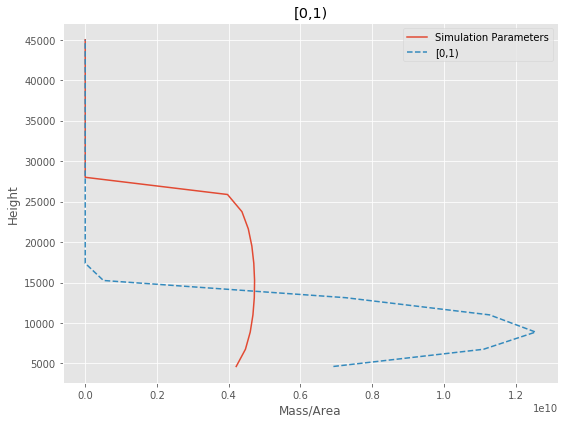

[0,1) Run Time: 0.15469 minutes


41653079925.06626
========[1,2)========
Run 0===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.14998	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 14081.36069	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 16
SSE: 0.19983367570851035


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,320.1","14,081.4"
u,0.001,0.001
v,-0.001,-0.001


Run 0 Time: 0.008 minutes


Estimated remaining run time: 0.148 minutes


Run 1===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.16287	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44743.09896	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 21
SSE: 0.2974314502618382


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"33,794.1","44,743.1"
u,0.001,0.001
v,-0.001,-0.001


Run 1 Time: 0.010 minutes


Estimated remaining run time: 0.173 minutes


Run 2===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.15001	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 14080.87254	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 16
SSE: 0.19983367354216658


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,557.3","14,080.9"
u,0.001,0.001
v,-0.001,-0.001


Run 2 Time: 0.008 minutes


Estimated remaining run time: 0.133 minutes


Run 3===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.14998	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 14081.28557	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 16
SSE: 0.19983367473609162


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"23,432.1","14,081.3"
u,0.001,0.001
v,-0.001,-0.001


Run 3 Time: 0.008 minutes


Estimated remaining run time: 0.121 minutes


Run 4===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.16282	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44743.08795	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 21
SSE: 0.29743145026154305


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"30,813.7","44,743.1"
u,0.001,0.001
v,-0.001,-0.001


Run 4 Time: 0.010 minutes


Estimated remaining run time: 0.148 minutes


Run 5===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.16285	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44743.09434	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 21
SSE: 0.2974314502611923


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"32,041.2","44,743.1"
u,0.001,0.001
v,-0.001,-0.001


Run 5 Time: 0.010 minutes


Estimated remaining run time: 0.139 minutes


Run 6===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.62693	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 6922.65901	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 12
SSE: 0.15449636610904194


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"8,585.2","6,922.66"
u,0.001,0.001
v,-0.001,-0.001


Run 6 Time: 0.006 minutes


Estimated remaining run time: 0.074 minutes


Run 7===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.16284	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44743.09266	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 20
SSE: 0.29743145026114487


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"35,275.9","44,743.1"
u,0.001,0.001
v,-0.001,-0.001


Run 7 Time: 0.010 minutes


Estimated remaining run time: 0.116 minutes


Run 8===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.15000	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 14080.94885	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 11
SSE: 0.1998336732334066


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"13,422.7","14,080.9"
u,0.001,0.001
v,-0.001,-0.001


Run 8 Time: 0.005 minutes


Estimated remaining run time: 0.060 minutes


Run 9===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.15001	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 14080.89872	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 16
SSE: 0.19983367340920058


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,135","14,080.9"
u,0.001,0.001
v,-0.001,-0.001


Run 9 Time: 0.008 minutes


Estimated remaining run time: 0.076 minutes


Run 10===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82195	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.19264	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 27
SSE: 0.15527642712057727


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"21,712.2","4,626.19"
u,0.001,0.001
v,-0.001,-0.001


Run 10 Time: 0.013 minutes


Estimated remaining run time: 0.115 minutes


Run 11===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.16286	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44743.09741	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 21
SSE: 0.29743145026153756


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"33,191","44,743.1"
u,0.001,0.001
v,-0.001,-0.001


Run 11 Time: 0.010 minutes


Estimated remaining run time: 0.077 minutes


Run 12===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.16287	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44743.09976	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 21
SSE: 0.29743145026202805


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"30,001.9","44,743.1"
u,0.001,0.001
v,-0.001,-0.001


Run 12 Time: 0.010 minutes


Estimated remaining run time: 0.067 minutes


Run 13===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.16279	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44743.08062	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 21
SSE: 0.2974314502637262


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"31,183.3","44,743.1"
u,0.001,0.001
v,-0.001,-0.001


Run 13 Time: 0.010 minutes


Estimated remaining run time: 0.061 minutes


Run 14===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82205	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.11816	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 0.1552764270182282


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"22,668.6","4,625.12"
u,0.001,0.001
v,-0.001,-0.001


Run 14 Time: 0.011 minutes


Estimated remaining run time: 0.055 minutes


Run 15===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.62691	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 6923.01966	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 15
SSE: 0.15449636345356713


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"10,826.1","6,923.02"
u,0.001,0.001
v,-0.001,-0.001


Run 15 Time: 0.007 minutes


Estimated remaining run time: 0.029 minutes


Run 16===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.16285	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44743.09382	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 22
SSE: 0.2974314502611668


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"31,473.5","44,743.1"
u,0.001,0.001
v,-0.001,-0.001


Run 16 Time: 0.010 minutes


Estimated remaining run time: 0.031 minutes


Run 17===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.15004	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 14080.40462	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 16
SSE: 0.1998336806849192


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"18,249.1","14,080.4"
u,0.001,0.001
v,-0.001,-0.001


Run 17 Time: 0.008 minutes


Estimated remaining run time: 0.017 minutes


Run 18===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.14997	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 14081.44223	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 16
SSE: 0.19983367702679192


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"18,335.6","14,081.4"
u,0.001,0.001
v,-0.001,-0.001


Run 18 Time: 0.008 minutes


Estimated remaining run time: 0.008 minutes


Run 19===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.15000	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 14081.00109	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 16
SSE: 0.19983367316042439


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"24,009.8","14,081"
u,0.001,0.001
v,-0.001,-0.001


Run 19 Time: 0.008 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.17552 minutes


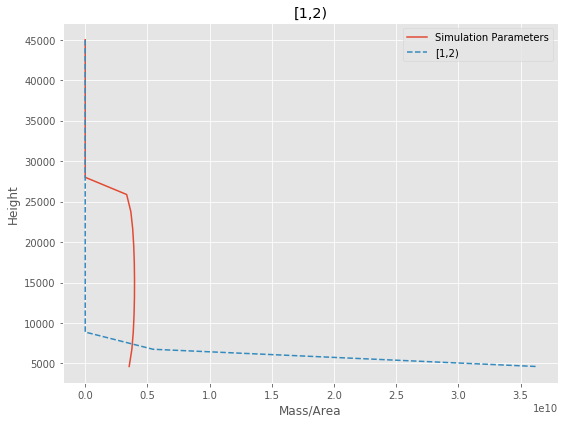

[1,2) Run Time: 0.17760 minutes


27231525112.606926
========[2,3)========
Run 0===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.44347	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44805.81899	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 21
SSE: 0.31096060009331095


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"30,132.4","44,805.8"
u,0.001,0.001
v,-0.001,-0.001


Run 0 Time: 0.010 minutes


Estimated remaining run time: 0.193 minutes


Run 1===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.44348	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44805.82141	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 21
SSE: 0.31096060009191917


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"35,071.4","44,805.8"
u,0.001,0.001
v,-0.001,-0.001


Run 1 Time: 0.010 minutes


Estimated remaining run time: 0.183 minutes


Run 2===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.44347	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44805.82036	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 0.31096060009246546


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"20,527.8","44,805.8"
u,0.001,0.001
v,-0.001,-0.001


Run 2 Time: 0.010 minutes


Estimated remaining run time: 0.177 minutes


Run 3===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.44349	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44805.82433	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 24
SSE: 0.31096060009090487


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,406.1","44,805.8"
u,0.001,0.001
v,-0.001,-0.001


Run 3 Time: 0.011 minutes


Estimated remaining run time: 0.179 minutes


Run 4===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.44352	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44805.82988	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 24
SSE: 0.310960600090977


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"21,271.4","44,805.8"
u,0.001,0.001
v,-0.001,-0.001


Run 4 Time: 0.011 minutes


Estimated remaining run time: 0.164 minutes


Run 5===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.44351	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44805.82763	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 0.31096060009063053


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"23,747.2","44,805.8"
u,0.001,0.001
v,-0.001,-0.001


Run 5 Time: 0.010 minutes


Estimated remaining run time: 0.146 minutes


Run 6===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.44353	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44805.83134	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 22
SSE: 0.3109606000914304


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"27,978.8","44,805.8"
u,0.001,0.001
v,-0.001,-0.001


Run 6 Time: 0.010 minutes


Estimated remaining run time: 0.132 minutes


Run 7===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.44347	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44805.82013	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 0.3109606000925924


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"22,931.5","44,805.8"
u,0.001,0.001
v,-0.001,-0.001


Run 7 Time: 0.010 minutes


Estimated remaining run time: 0.125 minutes


Run 8===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.44350	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44805.82596	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 25
SSE: 0.31096060009065396


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"18,450.6","44,805.8"
u,0.001,0.001
v,-0.001,-0.001


Run 8 Time: 0.013 minutes


Estimated remaining run time: 0.138 minutes


Run 9===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.44352	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44805.83045	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 22
SSE: 0.31096060009113047


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"27,032.7","44,805.8"
u,0.001,0.001
v,-0.001,-0.001


Run 9 Time: 0.010 minutes


Estimated remaining run time: 0.102 minutes


Run 10===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.44353	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44805.83114	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 24
SSE: 0.310960600091359


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"11,646.4","44,805.8"
u,0.001,0.001
v,-0.001,-0.001


Run 10 Time: 0.011 minutes


Estimated remaining run time: 0.101 minutes


Run 11===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.44354	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44805.83376	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 21
SSE: 0.31096060009258153


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"30,795.3","44,805.8"
u,0.001,0.001
v,-0.001,-0.001


Run 11 Time: 0.010 minutes


Estimated remaining run time: 0.077 minutes


Run 12===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.44347	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44805.82051	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 20
SSE: 0.31096060009238113


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"36,294.3","44,805.8"
u,0.001,0.001
v,-0.001,-0.001


Run 12 Time: 0.010 minutes


Estimated remaining run time: 0.067 minutes


Run 13===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.44350	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44805.82574	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 22
SSE: 0.3109606000906748


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"27,293.6","44,805.8"
u,0.001,0.001
v,-0.001,-0.001


Run 13 Time: 0.010 minutes


Estimated remaining run time: 0.059 minutes


Run 14===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.44353	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44805.83171	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 22
SSE: 0.3109606000915737


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"28,878.9","44,805.8"
u,0.001,0.001
v,-0.001,-0.001


Run 14 Time: 0.010 minutes


Estimated remaining run time: 0.052 minutes


Run 15===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.44352	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44805.82954	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 22
SSE: 0.31096060009089566


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"28,708.7","44,805.8"
u,0.001,0.001
v,-0.001,-0.001


Run 15 Time: 0.010 minutes


Estimated remaining run time: 0.040 minutes


Run 16===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.44348	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44805.82202	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 21
SSE: 0.31096060009164966


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"30,436.2","44,805.8"
u,0.001,0.001
v,-0.001,-0.001


Run 16 Time: 0.010 minutes


Estimated remaining run time: 0.030 minutes


Run 17===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.44351	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44805.82782	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 24
SSE: 0.31096060009064325


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"11,488.1","44,805.8"
u,0.001,0.001
v,-0.001,-0.001


Run 17 Time: 0.012 minutes


Estimated remaining run time: 0.024 minutes


Run 18===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.44353	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44805.83225	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 19
SSE: 0.3109606000918066


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"41,466.8","44,805.8"
u,0.001,0.001
v,-0.001,-0.001


Run 18 Time: 0.009 minutes


Estimated remaining run time: 0.009 minutes


Run 19===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.44350	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44805.82634	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 22
SSE: 0.3109606000906276


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"31,774.3","44,805.8"
u,0.001,0.001
v,-0.001,-0.001


Run 19 Time: 0.010 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.20807 minutes


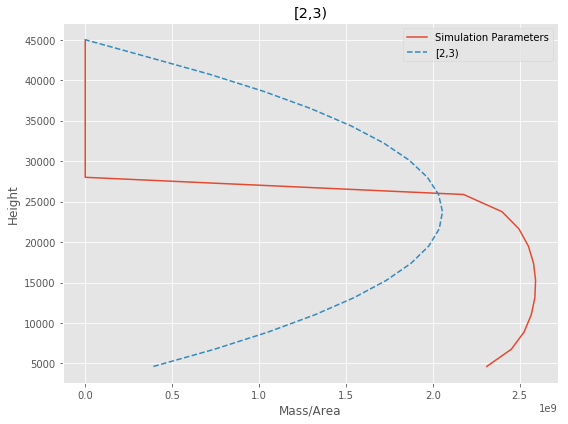

[2,3) Run Time: 0.21016 minutes


13865105854.019527
========[3,4)========
Run 0===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.71402	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44851.77185	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 24
SSE: 0.2226138950501113


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"21,309.9","44,851.8"
u,0.001,0.001
v,-0.001,-0.001


Run 0 Time: 0.011 minutes


Estimated remaining run time: 0.213 minutes


Run 1===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.71403	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44851.77394	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 26
SSE: 0.2226138950502185


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"17,816.4","44,851.8"
u,0.001,0.001
v,-0.001,-0.001


Run 1 Time: 0.012 minutes


Estimated remaining run time: 0.216 minutes


Run 2===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.71400	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44851.76975	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 22
SSE: 0.22261389505060294


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"29,575.3","44,851.8"
u,0.001,0.001
v,-0.001,-0.001


Run 2 Time: 0.010 minutes


Estimated remaining run time: 0.173 minutes


Run 3===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.71403	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44851.77354	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 18
SSE: 0.22261389505015083


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"43,093.4","44,851.8"
u,0.001,0.001
v,-0.001,-0.001


Run 3 Time: 0.009 minutes


Estimated remaining run time: 0.138 minutes


Run 4===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.71403	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44851.77323	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 0.2226138950501145


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"26,283.9","44,851.8"
u,0.001,0.001
v,-0.001,-0.001


Run 4 Time: 0.011 minutes


Estimated remaining run time: 0.160 minutes


Run 5===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.71399	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44851.76737	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 21
SSE: 0.2226138950518934


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"35,796.7","44,851.8"
u,0.001,0.001
v,-0.001,-0.001


Run 5 Time: 0.010 minutes


Estimated remaining run time: 0.135 minutes


Run 6===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.71399	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44851.76827	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 0.22261389505131307


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"9,802.38","44,851.8"
u,0.001,0.001
v,-0.001,-0.001


Run 6 Time: 0.011 minutes


Estimated remaining run time: 0.139 minutes


Run 7===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.71402	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44851.77215	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 0.2226138950500896


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"24,731.6","44,851.8"
u,0.001,0.001
v,-0.001,-0.001


Run 7 Time: 0.011 minutes


Estimated remaining run time: 0.128 minutes


Run 8===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.71400	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44851.76884	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 21
SSE: 0.22261389505100726


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"30,948.4","44,851.8"
u,0.001,0.001
v,-0.001,-0.001


Run 8 Time: 0.010 minutes


Estimated remaining run time: 0.106 minutes


Run 9===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.71400	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44851.77002	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 29
SSE: 0.22261389505050855


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"16,688.3","44,851.8"
u,0.001,0.001
v,-0.001,-0.001


Run 9 Time: 0.014 minutes


Estimated remaining run time: 0.138 minutes


Run 10===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.71402	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44851.77252	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 27
SSE: 0.2226138950500801


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"17,042.4","44,851.8"
u,0.001,0.001
v,-0.001,-0.001


Run 10 Time: 0.013 minutes


Estimated remaining run time: 0.117 minutes


Run 11===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.71404	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44851.77472	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 21
SSE: 0.22261389505041138


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"36,167.6","44,851.8"
u,0.001,0.001
v,-0.001,-0.001


Run 11 Time: 0.010 minutes


Estimated remaining run time: 0.081 minutes


Run 12===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.71402	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44851.77179	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 0.2226138950501164


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"25,560.4","44,851.8"
u,0.001,0.001
v,-0.001,-0.001


Run 12 Time: 0.011 minutes


Estimated remaining run time: 0.075 minutes


Run 13===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.71404	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44851.77555	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 22
SSE: 0.22261389505070706


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"31,680.2","44,851.8"
u,0.001,0.001
v,-0.001,-0.001


Run 13 Time: 0.011 minutes


Estimated remaining run time: 0.066 minutes


Run 14===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.71405	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44851.77719	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 25
SSE: 0.2226138950515714


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"15,011.9","44,851.8"
u,0.001,0.001
v,-0.001,-0.001


Run 14 Time: 0.011 minutes


Estimated remaining run time: 0.056 minutes


Run 15===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.71399	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44851.76828	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 26
SSE: 0.22261389505130783


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"17,926.4","44,851.8"
u,0.001,0.001
v,-0.001,-0.001


Run 15 Time: 0.012 minutes


Estimated remaining run time: 0.047 minutes


Run 16===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.71401	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44851.77044	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 24
SSE: 0.22261389505037651


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"12,826.6","44,851.8"
u,0.001,0.001
v,-0.001,-0.001


Run 16 Time: 0.011 minutes


Estimated remaining run time: 0.033 minutes


Run 17===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.71401	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44851.77137	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 0.222613895050171


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"7,315.61","44,851.8"
u,0.001,0.001
v,-0.001,-0.001


Run 17 Time: 0.011 minutes


Estimated remaining run time: 0.022 minutes


Run 18===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.71403	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44851.77353	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 0.2226138950501499


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"25,674.5","44,851.8"
u,0.001,0.001
v,-0.001,-0.001


Run 18 Time: 0.011 minutes


Estimated remaining run time: 0.011 minutes


Run 19===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = 5.71400	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 44851.76941	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 24
SSE: 0.22261389505073909


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"21,298.8","44,851.8"
u,0.001,0.001
v,-0.001,-0.001


Run 19 Time: 0.011 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.21901 minutes


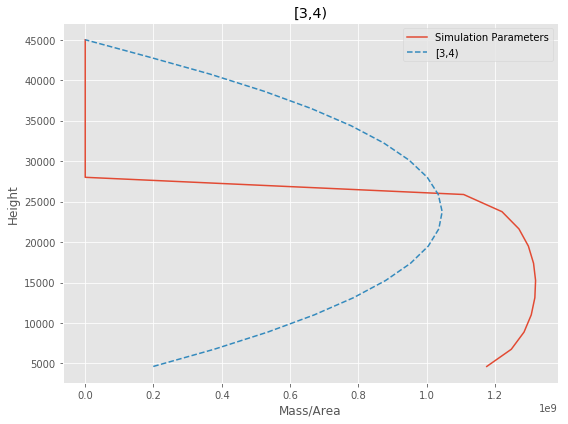

[3,4) Run Time: 0.22135 minutes


5497950099.919354
========[4,5)========
Run 0===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82204	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.28100	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 27
SSE: 0.20927660944229404


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"15,726.2","4,625.28"
u,0.001,0.001
v,-0.001,-0.001


Run 0 Time: 0.013 minutes


Estimated remaining run time: 0.242 minutes


Run 1===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82195	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.16282	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 21
SSE: 0.20927660955550276


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"9,727.5","4,626.16"
u,0.001,0.001
v,-0.001,-0.001


Run 1 Time: 0.010 minutes


Estimated remaining run time: 0.178 minutes


Run 2===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82201	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.56177	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 25
SSE: 0.20927660947833854


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"18,763.7","4,625.56"
u,0.001,0.001
v,-0.001,-0.001


Run 2 Time: 0.011 minutes


Estimated remaining run time: 0.182 minutes


Run 3===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82199	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.77916	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 17
SSE: 0.20927660950624763


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"7,273.12","4,625.78"
u,0.001,0.001
v,-0.001,-0.001


Run 3 Time: 0.009 minutes


Estimated remaining run time: 0.142 minutes


Run 4===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82199	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.78289	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 24
SSE: 0.2092766095067257


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,450","4,625.78"
u,0.001,0.001
v,-0.001,-0.001


Run 4 Time: 0.013 minutes


Estimated remaining run time: 0.191 minutes


Run 5===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82199	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.70565	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 25
SSE: 0.2092766094968102


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"13,983.8","4,625.71"
u,0.001,0.001
v,-0.001,-0.001


Run 5 Time: 0.011 minutes


Estimated remaining run time: 0.160 minutes


Run 6===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82194	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.26453	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 25
SSE: 0.20927660956856062


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"22,578.7","4,626.26"
u,0.001,0.001
v,-0.001,-0.001


Run 6 Time: 0.011 minutes


Estimated remaining run time: 0.149 minutes


Run 7===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82205	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.10923	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 0.2092766094202423


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"14,856.9","4,625.11"
u,0.001,0.001
v,-0.001,-0.001


Run 7 Time: 0.010 minutes


Estimated remaining run time: 0.125 minutes


Run 8===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82202	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.41770	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 22
SSE: 0.20927660945984253


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"12,173","4,625.42"
u,0.001,0.001
v,-0.001,-0.001


Run 8 Time: 0.010 minutes


Estimated remaining run time: 0.112 minutes


Run 9===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82198	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.89681	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 27
SSE: 0.20927660952135121


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,163.3","4,625.9"
u,0.001,0.001
v,-0.001,-0.001


Run 9 Time: 0.012 minutes


Estimated remaining run time: 0.122 minutes


Run 10===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82195	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.19118	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 0.20927660955914362


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,882.4","4,626.19"
u,0.001,0.001
v,-0.001,-0.001


Run 10 Time: 0.010 minutes


Estimated remaining run time: 0.094 minutes


Run 11===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82203	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.29601	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 25
SSE: 0.20927660944422027


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"22,328.5","4,625.3"
u,0.001,0.001
v,-0.001,-0.001


Run 11 Time: 0.012 minutes


Estimated remaining run time: 0.096 minutes


Run 12===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82201	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.55357	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 22
SSE: 0.20927660947728632


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"22,293.8","4,625.55"
u,0.001,0.001
v,-0.001,-0.001


Run 12 Time: 0.010 minutes


Estimated remaining run time: 0.073 minutes


Run 13===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82199	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.77919	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 20
SSE: 0.2092766095062517


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"10,195.2","4,625.78"
u,0.001,0.001
v,-0.001,-0.001


Run 13 Time: 0.010 minutes


Estimated remaining run time: 0.059 minutes


Run 14===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82203	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.34115	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 0.20927660945001603


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,728.4","4,625.34"
u,0.001,0.001
v,-0.001,-0.001


Run 14 Time: 0.011 minutes


Estimated remaining run time: 0.053 minutes


Run 15===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82197	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.97846	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 19
SSE: 0.20927660953183375


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"12,014.5","4,625.98"
u,0.001,0.001
v,-0.001,-0.001


Run 15 Time: 0.009 minutes


Estimated remaining run time: 0.037 minutes


Run 16===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82203	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.30491	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 0.20927660944536267


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"13,903.1","4,625.3"
u,0.001,0.001
v,-0.001,-0.001


Run 16 Time: 0.011 minutes


Estimated remaining run time: 0.032 minutes


Run 17===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82200	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.64344	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 27
SSE: 0.20927660948882343


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"16,400.9","4,625.64"
u,0.001,0.001
v,-0.001,-0.001


Run 17 Time: 0.012 minutes


Estimated remaining run time: 0.023 minutes


Run 18===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82193	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.35965	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 22
SSE: 0.20927660958077282


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,553.5","4,626.36"
u,0.001,0.001
v,-0.001,-0.001


Run 18 Time: 0.010 minutes


Estimated remaining run time: 0.010 minutes


Run 19===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82190	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.73142	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 17
SSE: 0.20927660962850256


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"8,572.68","4,626.73"
u,0.001,0.001
v,-0.001,-0.001


Run 19 Time: 0.008 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.21354 minutes


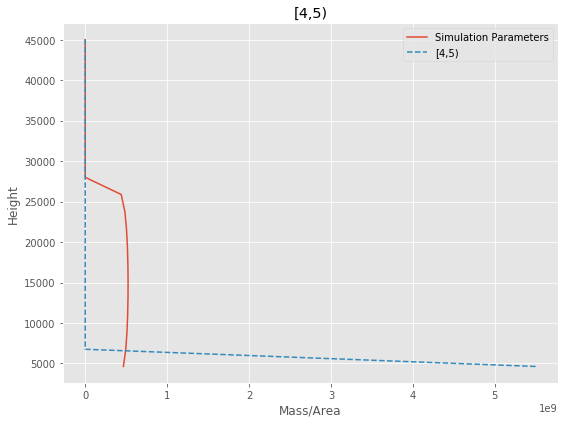

[4,5) Run Time: 0.21589 minutes


1697871340.2327414
========[5,6)========
Run 0===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82199	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.70829	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 25
SSE: 9804.541034376909


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"17,876.7","4,625.71"
u,0.001,0.001
v,-0.001,-0.001


Run 0 Time: 0.011 minutes


Estimated remaining run time: 0.218 minutes


Run 1===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82195	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.20063	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 13
SSE: 9804.541037338167


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"5,164.87","4,626.2"
u,0.001,0.001
v,-0.001,-0.001


Run 1 Time: 0.006 minutes


Estimated remaining run time: 0.108 minutes


Run 2===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82196	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.09943	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 20
SSE: 9804.541036729503


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"10,020.1","4,626.1"
u,0.001,0.001
v,-0.001,-0.001


Run 2 Time: 0.010 minutes


Estimated remaining run time: 0.177 minutes


Run 3===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82195	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.12484	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 25
SSE: 9804.54103688228


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"13,666.7","4,626.12"
u,0.001,0.001
v,-0.001,-0.001


Run 3 Time: 0.011 minutes


Estimated remaining run time: 0.183 minutes


Run 4===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82194	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.29485	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 20
SSE: 9804.541037904854


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"10,903.5","4,626.29"
u,0.001,0.001
v,-0.001,-0.001


Run 4 Time: 0.009 minutes


Estimated remaining run time: 0.137 minutes


Run 5===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82204	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.20049	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 22
SSE: 9804.541031322713


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"18,761","4,625.2"
u,0.001,0.001
v,-0.001,-0.001


Run 5 Time: 0.010 minutes


Estimated remaining run time: 0.146 minutes


Run 6===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82202	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.43516	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 25
SSE: 9804.541032734161


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"28,559.2","4,625.44"
u,0.001,0.001
v,-0.001,-0.001


Run 6 Time: 0.012 minutes


Estimated remaining run time: 0.152 minutes


Run 7===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82198	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.81043	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 26
SSE: 9804.541034991234


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"27,062.9","4,625.81"
u,0.001,0.001
v,-0.001,-0.001


Run 7 Time: 0.013 minutes


Estimated remaining run time: 0.156 minutes


Run 8===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00929	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 25
SSE: 9804.54103017277


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"21,012.2","4,625.01"
u,0.001,0.001
v,-0.001,-0.001


Run 8 Time: 0.013 minutes


Estimated remaining run time: 0.143 minutes


Run 9===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82205	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.09339	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 21
SSE: 9804.54103067859


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"14,734.7","4,625.09"
u,0.001,0.001
v,-0.001,-0.001


Run 9 Time: 0.011 minutes


Estimated remaining run time: 0.107 minutes


Run 10===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82200	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.62679	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 26
SSE: 9804.541033886722


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,269.9","4,625.63"
u,0.001,0.001
v,-0.001,-0.001


Run 10 Time: 0.013 minutes


Estimated remaining run time: 0.117 minutes


Run 11===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82204	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.21830	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 26
SSE: 9804.541031429833


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"26,720","4,625.22"
u,0.001,0.001
v,-0.001,-0.001


Run 11 Time: 0.012 minutes


Estimated remaining run time: 0.096 minutes


Run 12===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82204	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.22515	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 19
SSE: 9804.54103147107


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"7,663.64","4,625.23"
u,0.001,0.001
v,-0.001,-0.001


Run 12 Time: 0.009 minutes


Estimated remaining run time: 0.062 minutes


Run 13===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82192	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4626.47676	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 24
SSE: 9804.541038999043


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"14,956.6","4,626.48"
u,0.001,0.001
v,-0.001,-0.001


Run 13 Time: 0.011 minutes


Estimated remaining run time: 0.069 minutes


Run 14===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82197	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.96884	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 24
SSE: 9804.541035944023


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"22,150.3","4,625.97"
u,0.001,0.001
v,-0.001,-0.001


Run 14 Time: 0.011 minutes


Estimated remaining run time: 0.056 minutes


Run 15===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82204	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.19101	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 24
SSE: 9804.541031265731


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"18,853","4,625.19"
u,0.001,0.001
v,-0.001,-0.001


Run 15 Time: 0.011 minutes


Estimated remaining run time: 0.046 minutes


Run 16===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82203	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.37523	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 23
SSE: 9804.541032373705


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"20,488.6","4,625.38"
u,0.001,0.001
v,-0.001,-0.001


Run 16 Time: 0.011 minutes


Estimated remaining run time: 0.032 minutes


Run 17===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82199	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.79186	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 26
SSE: 9804.541034879516


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"32,442.7","4,625.79"
u,0.001,0.001
v,-0.001,-0.001


Run 17 Time: 0.012 minutes


Estimated remaining run time: 0.024 minutes


Run 18===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82202	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.42094	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 22
SSE: 9804.541032648596


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"9,776.81","4,625.42"
u,0.001,0.001
v,-0.001,-0.001


Run 18 Time: 0.011 minutes


Estimated remaining run time: 0.011 minutes


Run 19===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82198	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.82145	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 27
SSE: 9804.541035057524


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"38,393.1","4,625.82"
u,0.001,0.001
v,-0.001,-0.001


Run 19 Time: 0.012 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.22109 minutes


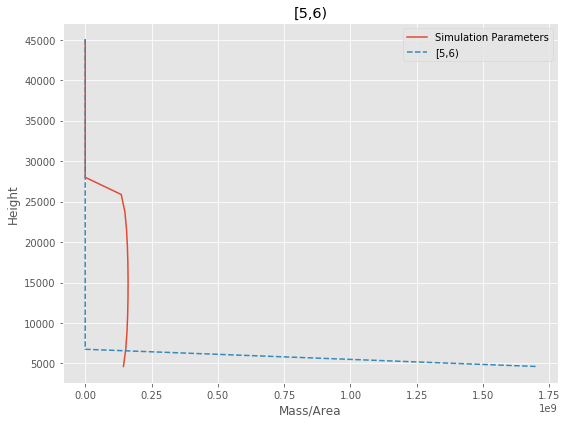

[5,6) Run Time: 0.22318 minutes


408352426.76486474
========[6,7)========
Run 0===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.01267	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 33
SSE: 17218665.81675969


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"17,677.9","4,625.01"
u,0.001,0.001
v,-0.001,-0.001


Run 0 Time: 0.015 minutes


Estimated remaining run time: 0.292 minutes


Run 1===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00839	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 38
SSE: 17218665.816714514


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"30,299.3","4,625.01"
u,0.001,0.001
v,-0.001,-0.001


Run 1 Time: 0.018 minutes


Estimated remaining run time: 0.333 minutes


Run 2===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.01480	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 33
SSE: 17218665.816782247


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"12,274.6","4,625.01"
u,0.001,0.001
v,-0.001,-0.001


Run 2 Time: 0.016 minutes


Estimated remaining run time: 0.266 minutes


Run 3===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.01008	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 37
SSE: 17218665.816732347


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"28,068.5","4,625.01"
u,0.001,0.001
v,-0.001,-0.001


Run 3 Time: 0.020 minutes


Estimated remaining run time: 0.312 minutes


Run 4===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00311	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 28
SSE: 17218665.816658802


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"6,455.53","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 4 Time: 0.015 minutes


Estimated remaining run time: 0.219 minutes


Run 5===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00591	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 29
SSE: 17218665.816688366


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"9,179.63","4,625.01"
u,0.001,0.001
v,-0.001,-0.001


Run 5 Time: 0.015 minutes


Estimated remaining run time: 0.208 minutes


Run 6===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00965	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 34
SSE: 17218665.816727884


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"28,656.7","4,625.01"
u,0.001,0.001
v,-0.001,-0.001


Run 6 Time: 0.017 minutes


Estimated remaining run time: 0.217 minutes


Run 7===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00188	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 30
SSE: 17218665.816645786


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"21,782.3","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 7 Time: 0.014 minutes


Estimated remaining run time: 0.169 minutes


Run 8===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00342	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 35
SSE: 17218665.816662025


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"34,537.8","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 8 Time: 0.016 minutes


Estimated remaining run time: 0.175 minutes


Run 9===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00956	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 35
SSE: 17218665.816726852


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,619","4,625.01"
u,0.001,0.001
v,-0.001,-0.001


Run 9 Time: 0.016 minutes


Estimated remaining run time: 0.164 minutes


Run 10===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.01168	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 31
SSE: 17218665.81674928


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"10,290.5","4,625.01"
u,0.001,0.001
v,-0.001,-0.001


Run 10 Time: 0.015 minutes


Estimated remaining run time: 0.134 minutes


Run 11===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.01027	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 37
SSE: 17218665.81673438


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"18,162","4,625.01"
u,0.001,0.001
v,-0.001,-0.001


Run 11 Time: 0.017 minutes


Estimated remaining run time: 0.140 minutes


Run 12===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00228	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 36
SSE: 17218665.816650026


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,619.1","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 12 Time: 0.017 minutes


Estimated remaining run time: 0.118 minutes


Run 13===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00969	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 29
SSE: 17218665.816728316


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"6,423.19","4,625.01"
u,0.001,0.001
v,-0.001,-0.001


Run 13 Time: 0.014 minutes


Estimated remaining run time: 0.081 minutes


Run 14===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.01219	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 33
SSE: 17218665.816754695


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"21,054","4,625.01"
u,0.001,0.001
v,-0.001,-0.001


Run 14 Time: 0.015 minutes


Estimated remaining run time: 0.074 minutes


Run 15===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00332	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 30
SSE: 17218665.816660963


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"24,276.9","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 15 Time: 0.014 minutes


Estimated remaining run time: 0.056 minutes


Run 16===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.01107	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 33
SSE: 17218665.816742875


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"37,242.8","4,625.01"
u,0.001,0.001
v,-0.001,-0.001


Run 16 Time: 0.015 minutes


Estimated remaining run time: 0.046 minutes


Run 17===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00019	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 37
SSE: 17218665.81662795


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"35,010.7","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 17 Time: 0.020 minutes


Estimated remaining run time: 0.040 minutes


Run 18===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00953	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 38
SSE: 17218665.81672658


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"44,779.7","4,625.01"
u,0.001,0.001
v,-0.001,-0.001


Run 18 Time: 0.019 minutes


Estimated remaining run time: 0.019 minutes


Run 19===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.01222	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 27
SSE: 17218665.816754974


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"10,221.5","4,625.01"
u,0.001,0.001
v,-0.001,-0.001


Run 19 Time: 0.014 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.32109 minutes


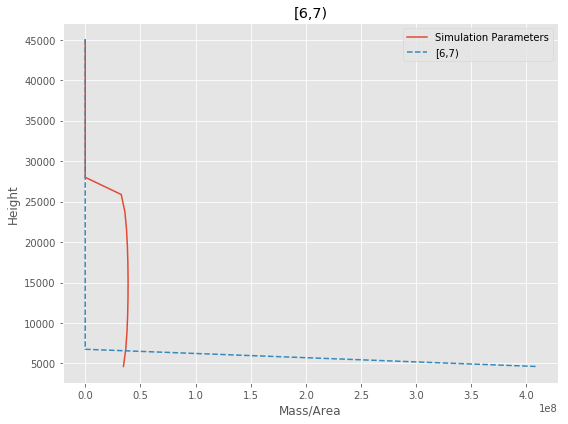

[6,7) Run Time: 0.32448 minutes


76487749.64436601
========[7,8)========
Run 0===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 51
SSE: 53291077402.08005


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"15,698.2","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 0 Time: 0.023 minutes


Estimated remaining run time: 0.445 minutes


Run 1===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 51
SSE: 53291077402.08002


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"11,290.4","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 1 Time: 0.023 minutes


Estimated remaining run time: 0.417 minutes


Run 2===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 53
SSE: 53291077402.079926


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"23,125.3","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 2 Time: 0.026 minutes


Estimated remaining run time: 0.434 minutes


Run 3===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 44
SSE: 53291077402.07995


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"5,624.1","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 3 Time: 0.021 minutes


Estimated remaining run time: 0.338 minutes


Run 4===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 48
SSE: 53291077402.079926


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"15,566.1","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 4 Time: 0.025 minutes


Estimated remaining run time: 0.375 minutes


Run 5===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 55
SSE: 53291077402.08008


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"17,362.1","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 5 Time: 0.027 minutes


Estimated remaining run time: 0.372 minutes


Run 6===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 49
SSE: 53291077402.07999


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"28,978.4","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 6 Time: 0.022 minutes


Estimated remaining run time: 0.291 minutes


Run 7===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 56
SSE: 53291077402.07995


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"23,037.7","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 7 Time: 0.026 minutes


Estimated remaining run time: 0.316 minutes


Run 8===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 48
SSE: 53291077402.07995


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"9,183.22","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 8 Time: 0.024 minutes


Estimated remaining run time: 0.269 minutes


Run 9===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 56
SSE: 53291077402.079994


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,161.8","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 9 Time: 0.027 minutes


Estimated remaining run time: 0.266 minutes


Run 10===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 43
SSE: 53291077402.08001


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"7,188.42","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 10 Time: 0.020 minutes


Estimated remaining run time: 0.180 minutes


Run 11===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 54
SSE: 53291077402.08007


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"15,860.1","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 11 Time: 0.028 minutes


Estimated remaining run time: 0.221 minutes


Run 12===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 50
SSE: 53291077402.07995


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"18,211.1","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 12 Time: 0.023 minutes


Estimated remaining run time: 0.159 minutes


Run 13===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 52
SSE: 53291077402.07996


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"21,234.5","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 13 Time: 0.026 minutes


Estimated remaining run time: 0.156 minutes


Run 14===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 50
SSE: 53291077402.079926


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"35,346.2","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 14 Time: 0.026 minutes


Estimated remaining run time: 0.129 minutes


Run 15===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 56
SSE: 53291077402.07999


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"16,024.7","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 15 Time: 0.026 minutes


Estimated remaining run time: 0.103 minutes


Run 16===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 58
SSE: 53291077402.079994


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"20,372.5","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 16 Time: 0.026 minutes


Estimated remaining run time: 0.077 minutes


Run 17===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 54
SSE: 53291077402.08003


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"30,297.2","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 17 Time: 0.025 minutes


Estimated remaining run time: 0.051 minutes


Run 18===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 53
SSE: 53291077402.08005


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"26,851.6","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 18 Time: 0.026 minutes


Estimated remaining run time: 0.026 minutes


Run 19===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 46
SSE: 53291077402.08001


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"20,187.6","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 19 Time: 0.021 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.49062 minutes


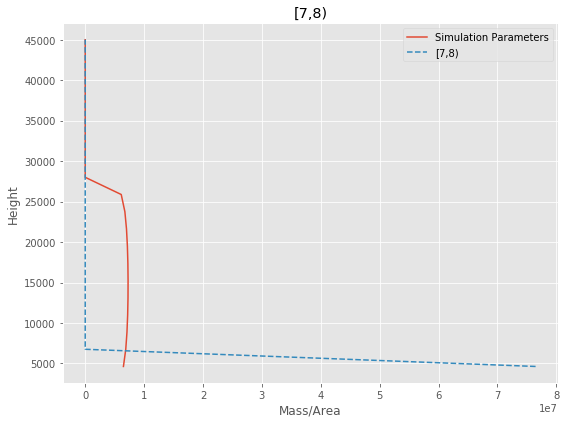

[7,8) Run Time: 0.49297 minutes


11157708.369601538
========[8,9)========
Run 0===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 59
SSE: 134994126639478.77


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"17,679","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 0 Time: 0.027 minutes


Estimated remaining run time: 0.515 minutes


Run 1===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 61
SSE: 134994126639478.77


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"17,355.4","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 1 Time: 0.031 minutes


Estimated remaining run time: 0.558 minutes


Run 2===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 53
SSE: 134994126639478.77


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"13,154.4","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 2 Time: 0.026 minutes


Estimated remaining run time: 0.443 minutes


Run 3===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 57
SSE: 134994126639478.8


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"21,581.6","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 3 Time: 0.027 minutes


Estimated remaining run time: 0.433 minutes


Run 4===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 58
SSE: 134994126639478.77


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"32,155","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 4 Time: 0.029 minutes


Estimated remaining run time: 0.430 minutes


Run 5===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 59
SSE: 134994126639478.77


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"17,211","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 5 Time: 0.028 minutes


Estimated remaining run time: 0.394 minutes


Run 6===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 64
SSE: 134994126639478.77


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"21,310.5","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 6 Time: 0.029 minutes


Estimated remaining run time: 0.383 minutes


Run 7===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 56
SSE: 134994126639478.77


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"35,723.9","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 7 Time: 0.026 minutes


Estimated remaining run time: 0.306 minutes


Run 8===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 59
SSE: 134994126639478.8


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"14,282","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 8 Time: 0.027 minutes


Estimated remaining run time: 0.295 minutes


Run 9===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 58
SSE: 134994126639478.8


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"23,170","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 9 Time: 0.028 minutes


Estimated remaining run time: 0.279 minutes


Run 10===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 60
SSE: 134994126639478.8


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"20,581.8","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 10 Time: 0.031 minutes


Estimated remaining run time: 0.277 minutes


Run 11===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 57
SSE: 134994126639478.77


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"31,585.2","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 11 Time: 0.026 minutes


Estimated remaining run time: 0.208 minutes


Run 12===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 58
SSE: 134994126639478.77


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"14,796.2","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 12 Time: 0.027 minutes


Estimated remaining run time: 0.188 minutes


Run 13===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 53
SSE: 134994126639478.8


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"17,096.6","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 13 Time: 0.026 minutes


Estimated remaining run time: 0.155 minutes


Run 14===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 54
SSE: 134994126639478.8


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"34,540.6","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 14 Time: 0.027 minutes


Estimated remaining run time: 0.134 minutes


Run 15===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 59
SSE: 134994126639478.77


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"31,752.7","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 15 Time: 0.027 minutes


Estimated remaining run time: 0.108 minutes


Run 16===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 61
SSE: 134994126639478.77


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"34,117","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 16 Time: 0.030 minutes


Estimated remaining run time: 0.091 minutes


Run 17===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 54
SSE: 134994126639478.77


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"29,492.7","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 17 Time: 0.025 minutes


Estimated remaining run time: 0.049 minutes


Run 18===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 58
SSE: 134994126639478.77


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"11,884.9","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 18 Time: 0.030 minutes


Estimated remaining run time: 0.030 minutes


Run 19===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 58
SSE: 134994126639478.77


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"15,235","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 19 Time: 0.028 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.55312 minutes


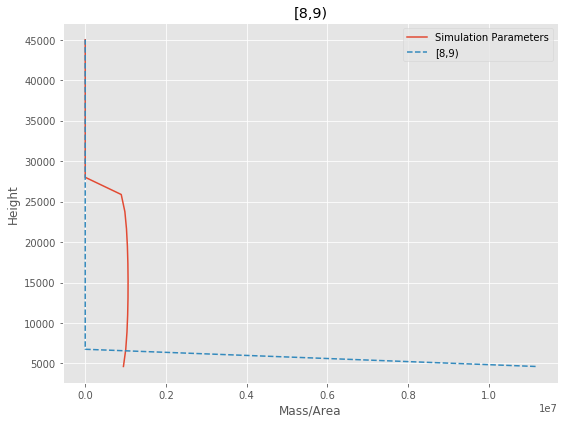

[8,9) Run Time: 0.55547 minutes


1267606.6470672598
========[9,10)========
Run 0===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 53
SSE: 4.287209712977659e+17


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"25,753.4","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 0 Time: 0.025 minutes


Estimated remaining run time: 0.475 minutes


Run 1===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 57
SSE: 4.2872097129776595e+17


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"21,072.9","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 1 Time: 0.027 minutes


Estimated remaining run time: 0.487 minutes


Run 2===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 61
SSE: 4.287209712977659e+17


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"34,107.8","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 2 Time: 0.028 minutes


Estimated remaining run time: 0.478 minutes


Run 3===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 56
SSE: 4.287209712977659e+17


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"13,177.7","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 3 Time: 0.025 minutes


Estimated remaining run time: 0.404 minutes


Run 4===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 59
SSE: 4.287209712977659e+17


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"26,987.2","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 4 Time: 0.029 minutes


Estimated remaining run time: 0.438 minutes


Run 5===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 53
SSE: 4.2872097129776595e+17


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"14,919.1","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 5 Time: 0.025 minutes


Estimated remaining run time: 0.354 minutes


Run 6===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 59
SSE: 4.287209712977659e+17


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"15,192.6","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 6 Time: 0.028 minutes


Estimated remaining run time: 0.359 minutes


Run 7===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 49
SSE: 4.2872097129776595e+17


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"9,566.14","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 7 Time: 0.024 minutes


Estimated remaining run time: 0.284 minutes


Run 8===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 54
SSE: 4.287209712977659e+17


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"13,070.8","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 8 Time: 0.027 minutes


Estimated remaining run time: 0.301 minutes


Run 9===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 58
SSE: 4.287209712977659e+17


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"22,100.6","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 9 Time: 0.027 minutes


Estimated remaining run time: 0.271 minutes


Run 10===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 56
SSE: 4.287209712977659e+17


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"25,041.2","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 10 Time: 0.027 minutes


Estimated remaining run time: 0.241 minutes


Run 11===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 64
SSE: 4.287209712977659e+17


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"23,742.3","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 11 Time: 0.030 minutes


Estimated remaining run time: 0.240 minutes


Run 12===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 59
SSE: 4.287209712977659e+17


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"29,920","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 12 Time: 0.028 minutes


Estimated remaining run time: 0.195 minutes


Run 13===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 59
SSE: 4.2872097129776595e+17


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"30,571.3","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 13 Time: 0.029 minutes


Estimated remaining run time: 0.172 minutes


Run 14===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 59
SSE: 4.287209712977659e+17


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"18,052.3","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 14 Time: 0.027 minutes


Estimated remaining run time: 0.134 minutes


Run 15===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 62
SSE: 4.287209712977659e+17


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"15,130.1","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 15 Time: 0.029 minutes


Estimated remaining run time: 0.118 minutes


Run 16===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 59
SSE: 4.287209712977659e+17


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"31,835.9","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 16 Time: 0.027 minutes


Estimated remaining run time: 0.082 minutes


Run 17===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 58
SSE: 4.287209712977659e+17


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"17,604.4","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 17 Time: 0.032 minutes


Estimated remaining run time: 0.063 minutes


Run 18===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 59
SSE: 4.2872097129776595e+17


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"24,402.8","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 18 Time: 0.029 minutes


Estimated remaining run time: 0.029 minutes


Run 19===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 64
SSE: 4.287209712977659e+17


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"33,366.5","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 19 Time: 0.033 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.55547 minutes


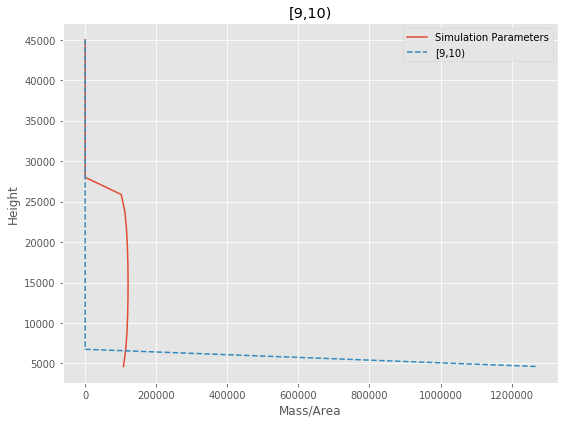

[9,10) Run Time: 0.55781 minutes


112155.45181775806
========[10,11)========
Run 0===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 58
SSE: 2.777049921484037e+20


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"25,422.1","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 0 Time: 0.028 minutes


Estimated remaining run time: 0.539 minutes


Run 1===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 53
SSE: 2.777049921484037e+20


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"14,544.2","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 1 Time: 0.026 minutes


Estimated remaining run time: 0.473 minutes


Run 2===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 60
SSE: 2.777049921484037e+20


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"24,786","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 2 Time: 0.029 minutes


Estimated remaining run time: 0.491 minutes


Run 3===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 58
SSE: 2.777049921484037e+20


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"24,870.8","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 3 Time: 0.030 minutes


Estimated remaining run time: 0.487 minutes


Run 4===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 59
SSE: 2.777049921484037e+20


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"32,715.2","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 4 Time: 0.032 minutes


Estimated remaining run time: 0.473 minutes


Run 5===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 57
SSE: 2.777049921484037e+20


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,577.3","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 5 Time: 0.030 minutes


Estimated remaining run time: 0.419 minutes


Run 6===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 57
SSE: 2.777049921484037e+20


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"22,554.1","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 6 Time: 0.030 minutes


Estimated remaining run time: 0.386 minutes


Run 7===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 55
SSE: 2.7770499214840375e+20


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"24,228","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 7 Time: 0.027 minutes


Estimated remaining run time: 0.328 minutes


Run 8===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 58
SSE: 2.7770499214840375e+20


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"25,792.9","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 8 Time: 0.029 minutes


Estimated remaining run time: 0.315 minutes


Run 9===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 49
SSE: 2.777049921484037e+20


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"7,495.2","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 9 Time: 0.026 minutes


Estimated remaining run time: 0.263 minutes


Run 10===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 55
SSE: 2.777049921484037e+20


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"14,573.3","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 10 Time: 0.029 minutes


Estimated remaining run time: 0.258 minutes


Run 11===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 58
SSE: 2.777049921484037e+20


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,438.2","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 11 Time: 0.030 minutes


Estimated remaining run time: 0.244 minutes


Run 12===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 58
SSE: 2.777049921484037e+20


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"13,400.3","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 12 Time: 0.027 minutes


Estimated remaining run time: 0.190 minutes


Run 13===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 60
SSE: 2.777049921484037e+20


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"19,188","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 13 Time: 0.028 minutes


Estimated remaining run time: 0.166 minutes


Run 14===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 57
SSE: 2.7770499214840375e+20


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"33,732.5","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 14 Time: 0.027 minutes


Estimated remaining run time: 0.137 minutes


Run 15===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 59
SSE: 2.777049921484037e+20


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"13,544.2","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 15 Time: 0.028 minutes


Estimated remaining run time: 0.111 minutes


Run 16===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 47
SSE: 2.777049921484037e+20


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"7,731.57","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 16 Time: 0.021 minutes


Estimated remaining run time: 0.063 minutes


Run 17===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 59
SSE: 2.777049921484037e+20


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"16,159.5","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 17 Time: 0.027 minutes


Estimated remaining run time: 0.053 minutes


Run 18===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 56
SSE: 2.777049921484037e+20


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"32,688.5","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 18 Time: 0.026 minutes


Estimated remaining run time: 0.026 minutes


Run 19===========================================================================
2
a* = 0.00000	b* = 0.00000	            h1* = -0.82206	u* = 0.00100	v* = -0.00100	            D* = 11.43026	ftt* = 8.18869	TM* = 26.24473
a = 2.00000	b = 2.00000	            h1 = 4625.00000	u = 0.00100	v = -0.00100	            D = 92066.00000	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 55
SSE: 2.777049921484037e+20


,Priors,Posteriors
D,"92,066","92,066"
M,2.5e+11,2.5e+11
a,2,2
b,2,2
ftt,"3,600","3,600"
h1,"30,599.7","4,625"
u,0.001,0.001
v,-0.001,-0.001


Run 19 Time: 0.027 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.55755 minutes


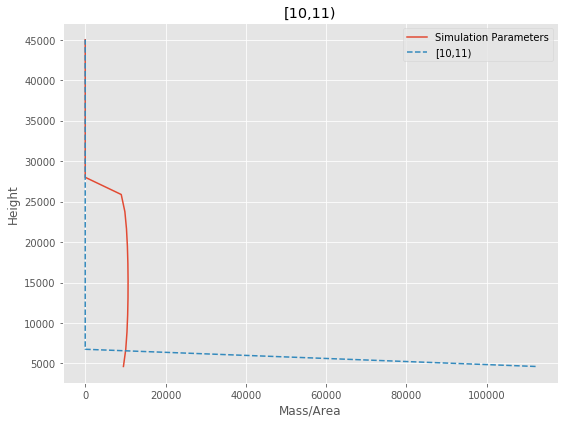

[10,11) Run Time: 0.56094 minutes


Total Run Time: 5.53307 minutes


In [17]:
data = obs_df

H = 45000

t_tot = process_time()
single_run_time = 0

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
inverted_masses_list = []
params_list = []


for phi_step in phi_steps:
    t = process_time()
    
    phi_df = data.copy()
    
    phi_df["MassArea"] = phi_df["MassArea"]*phi_df[phi_step["interval"]]/100
    phi_df[phi_step["interval"]] = 100
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    print(mass_in_phi)
    
    print("========%s========"%phi_step["interval"])
    
#     out = gaussian_stack_inversion(
#         phi_df, len(phi_df), 20, config["VENT_ELEVATION"], 
#         H, 2500, [phi_step],
#         invert_params=invert_params,
#         priors=priors_vals,
#         column_cap=H)
#     inversion_table, params, sol, sse, plume_trace, param_trace, sse_trace = out
    
    out = gaussian_stack_multi_run(
        phi_df, len(data), 20, 
        config["VENT_ELEVATION"], 
        H, 0, [phi_step], 
        param_config, runs=20, column_cap=H
    )
    
    masses_list, sse_list, params_runs, priors_list, heights = out
    
    best = np.argsort(sse_list)
    
    params = params_runs[best[0]]
    

    inv_mass = mass_dist_in_plume(params["a"],params["b"], 
                                config["VENT_ELEVATION"], 
                                params["h1"], 
                                heights,
                                mass_in_phi)
    inverted_masses_list += [inv_mass]
    params_list += [params]

     
    fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], 
                                config["VENT_ELEVATION"], 
                                config["PLUME_HEIGHT"], 
                                heights,
                                mass_in_phi)

    ax1.plot(q_mass, heights, label="Simulation Parameters")
    
    ax1.plot(inv_mass, heights, 
             '--', label=phi_step["interval"])
    ax1.legend()
    ax1.set_title("%s"%phi_step["interval"])
    ax1.set_ylabel("Height")
    ax1.set_xlabel("Mass/Area")

    plt.tight_layout()
    plt.show()
    run_time = process_time() - t
    print("%s Run Time: %.5f minutes\n\n"%(phi_step["interval"], run_time/60))

total_run_time = process_time() - t_tot

print("Total Run Time: %.5f minutes"%(total_run_time/60))

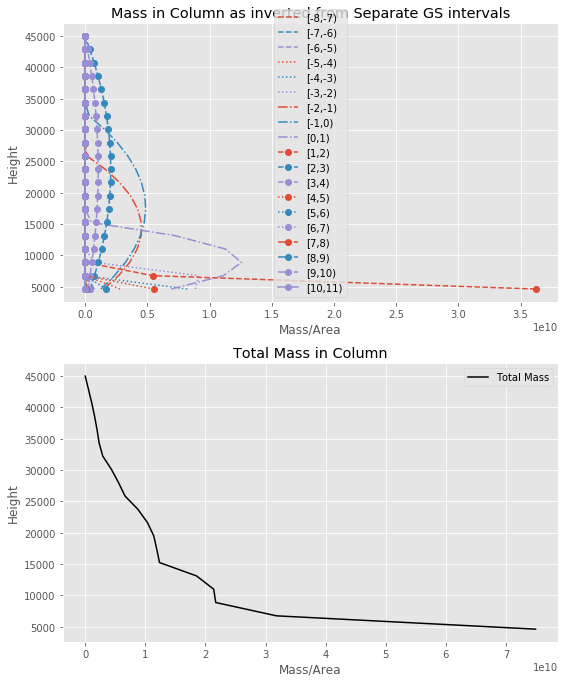

In [18]:
fig, axs = plt.subplots(2,1, figsize=(
    8, 10), facecolor='w', edgecolor='k')
ax1, ax2 = axs.ravel()
    
q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            heights,
            config["ERUPTION_MASS"])

linestyles = ["C0--","C1--","C2--","C0:","C1:","C2:","C0-.","C1-.","C2-.",
              "C0--o","C1--o","C2--o","C0:o","C1:o","C2:o","C0-.o","C1-.o","C2-.o",
             "C2-o",]

# ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
totmass = np.zeros(len(inverted_masses_list[0]))
    
for i, (phi_step, mass) in enumerate(zip(phi_steps, inverted_masses_list)):
    totmass += mass
    ax1.plot(mass, 
         heights, 
         linestyles[i], label=phi_step["interval"])
    
ax2.plot(totmass, heights, "k-", label="Total Mass")
ax1.legend()
ax2.legend()

ax1.set_title("Mass in Column as inverted from Separate GS intervals")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

ax2.set_title("Total Mass in Column")
ax2.set_ylabel("Height")
ax2.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()

In [19]:
params_df = pd.DataFrame(params_list)

params_df["Phi"] = [phi_step["interval"] for phi_step in phi_steps]

params_df = params_df[["Phi", "a", "b", "h1", "u", "v", "D", "ftt", "M"]]
display(params_df)

,Phi,a,b,h1,u,v,D,ftt,M
0,"[-8,-7)",2,2,"13,125",0.001,-0.001,"92,066","3,600",2.5e+11
1,"[-7,-6)",2,2,"4,625.01",0.001,-0.001,"92,066","3,600",2.5e+11
2,"[-6,-5)",2,2,"4,625",0.001,-0.001,"92,066","3,600",2.5e+11
3,"[-5,-4)",2,2,"4,625.04",0.001,-0.001,"92,066","3,600",2.5e+11
4,"[-4,-3)",2,2,"4,625.02",0.001,-0.001,"92,066","3,600",2.5e+11
5,"[-3,-2)",2,2,"8,998.42",0.001,-0.001,"92,066","3,600",2.5e+11
6,"[-2,-1)",2,2,"26,044.5",0.001,-0.001,"92,066","3,600",2.5e+11
7,"[-1,0)",2,2,"32,755.4",0.001,-0.001,"92,066","3,600",2.5e+11
8,"[0,1)",2,2,"15,381.5",0.001,-0.001,"92,066","3,600",2.5e+11
9,"[1,2)",2,2,"6,923.02",0.001,-0.001,"92,066","3,600",2.5e+11
